<a href="https://colab.research.google.com/github/lijingwang/hbvpy/blob/main/HBV_calibration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!git clone https://github.com/lijingwang/hbvpy.git
%cd hbvpy

In [ ]:
!pip install pyswarms

# HBV Model Calibration
## Equifinality, Optimization, Multi-Objective Analysis, ABC, and GLUE

This notebook demonstrates **multiple calibration and uncertainty estimation approaches** for the HBV hydrological model:

1. **Equifinality** — many parameter sets produce similar performance, motivating uncertainty methods
2. **Local Optimization (L-BFGS-B)** — gradient-based search, fast but trapped in local optima
3. **Global Optimization (PSO)** — particle swarm, explores broadly but still a point estimate
4. **Multi-Objective Optimization** — trade-offs between high-flow and low-flow objectives
5. **ABC** — Approximate Bayesian Computation (equal-weight approximate posterior via rejection sampling)
6. **GLUE** — Generalized Likelihood Uncertainty Estimation (weighted pseudo-posterior)
7. **Observation Error Impact** — how measurement noise affects each calibration method
8. **Prior vs Posterior Comparison** — distribution comparison across Bayesian methods
9. **Method Comparison** — summary of all approaches

## Section 0: Setup & Data Loading

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.lines import Line2D
from scipy.stats import qmc
from scipy.optimize import minimize
from pathlib import Path
import warnings
warnings.filterwarnings("ignore")
%config InlineBackend.figure_format = 'retina'

# Global font sizes for readability
plt.rcParams.update({
    'font.size': 14,
    'axes.titlesize': 16,
    'axes.labelsize': 14,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12,
    'legend.fontsize': 10,
    'figure.titlesize': 18,
})

from hbv import hbv_run
from metrics import kge, align_on_time

In [2]:
example_dir = Path("examples") / "Prof_Amir_AghaKouchak_example"

forcing = pd.read_csv(example_dir / "inputPrecipTemp.csv", parse_dates=["Time"])
forcing["Time"] = pd.to_datetime(forcing["Time"], format="%Y-%m-%d")
pet = pd.read_csv(example_dir / "inputMonthlyTempEvap.csv")
Qobs = pd.read_csv(example_dir / "Qobs.csv", parse_dates=["Time"])
Qobs["Time"] = pd.to_datetime(Qobs["Time"], format="%Y-%m-%d")

print(f"Simulation period: {forcing['Time'].min().date()} to {forcing['Time'].max().date()}")
print(f"Number of days: {len(forcing)}")

Simulation period: 1991-01-01 to 2000-12-30
Number of days: 3652


### Parameter Bounds

| Parameter | Description | Min | Max | Unit |
|-----------|-------------|-----|-----|------|
| d | Degree-day melt factor | 1.0 | 5.0 | mm/°C/day |
| fc | Field capacity | 100 | 400 | mm |
| beta | Runoff nonlinearity exponent | 1.0 | 5.0 | - |
| cpar | PET temperature correction | 0.01 | 0.3 | - |
| k0 | Quickflow coefficient | 0.1 | 0.5 | 1/day |
| lthr | Upper storage threshold | 1.0 | 20.0 | mm |
| k1 | Interflow coefficient | 0.01 | 0.2 | 1/day |
| k2 | Baseflow coefficient | 0.005 | 0.15 | 1/day |
| kp | Percolation coefficient | 0.01 | 0.15 | 1/day |
| pwp | Permanent wilting point | 50 | 200 | mm |

In [3]:
param_names = ["d", "fc", "beta", "cpar", "k0", "lthr", "k1", "k2", "kp", "pwp"]

param_bounds = {
    "d":    (1.0, 5.0),
    "fc":   (100.0, 400.0),
    "beta": (1.0, 5.0),
    "cpar": (0.01, 0.3),
    "k0":   (0.1, 0.5),
    "lthr": (1.0, 20.0),
    "k1":   (0.01, 0.2),
    "k2":   (0.005, 0.15),
    "kp":   (0.01, 0.15),
    "pwp":  (50.0, 200.0),
}

lower_bounds = np.array([param_bounds[p][0] for p in param_names])
upper_bounds = np.array([param_bounds[p][1] for p in param_names])
n_params = len(param_names)

WARMUP = 365  # skip first year for spin-up
print(f"Number of parameters: {n_params}")
print(f"Warmup period: {WARMUP} days")

Number of parameters: 10
Warmup period: 365 days


### Helper Functions & Observation Error Model

We define reusable helpers for running the model and computing objectives. The warmup period
(first 365 days) is excluded from all metric calculations.

**Observation errors** can be toggled on/off. When enabled, we use a heteroscedastic error
model realistic for streamflow gauging:
- σ(Q) = 0.05 × Q + 0.1 m³/s
- At low flows (Q ~ 1 m³/s): σ ≈ 0.15 m³/s (~15% relative error)
- At high flows (Q ~ 100 m³/s): σ ≈ 5.1 m³/s (~5% relative error)

In [6]:
# --- Observation error toggle ---
OBS_ERROR_ON = False  # Set True to add observation errors

def add_obs_error(obs_vals, seed=42):
    """Add iid observation errors to streamflow.
    Error model: sigma(Q) = 0.05*Q + 0.1
    Returns perturbed observations (or originals if OBS_ERROR_ON=False).
    """
    if not OBS_ERROR_ON:
        return obs_vals.copy()
    rng = np.random.RandomState(seed)
    sigma = 0.05 * np.abs(obs_vals) + 0.1
    return np.maximum(obs_vals + rng.normal(0, sigma), 0.0)  # clip to non-negative


def run_model(params):
    """Run HBV and return simulated Q (m3/s) array for the full period."""
    results, _ = hbv_run(
        forcing=forcing, pet_monthly=pet, params=np.asarray(params, dtype=float),
        area_km2=410.0, Tsnow_thresh=0.0,
        init_state={"snow": 0.0, "soil": 0.0, "s1": 0.0, "s2": 0.0},
    )
    return results["Q_m3s"].values


def get_obs_sim(Q_sim):
    """Align simulated Q with observations, skipping warmup period."""
    results_df = pd.DataFrame({"Time": forcing["Time"], "Q_m3s": Q_sim})
    results_post = results_df.iloc[WARMUP:].reset_index(drop=True)
    obs_vals, sim_vals, _ = align_on_time(
        modeled=results_post, observed=Qobs,
        modeled_value_col="Q_m3s", observed_value_col="Q (m3/s)",
    )
    # Apply observation error
    obs_vals = add_obs_error(obs_vals)
    return obs_vals, sim_vals


def kge_Q(params):
    """Compute KGE on discharge Q (emphasizes high flows)."""
    Q_sim = run_model(params)
    obs, sim = get_obs_sim(Q_sim)
    return kge(obs, sim)


def kge_invQ(params):
    """Compute KGE on 1/Q (emphasizes low flows)."""
    Q_sim = run_model(params)
    obs, sim = get_obs_sim(Q_sim)
    eps = 0.01
    return kge(1.0 / (obs + eps), 1.0 / (sim + eps))


# Quick test
test_params = np.array([2.74, 200.0, 2.0, 0.1, 0.2, 5.0, 0.05, 0.05, 0.05, 100.0])
print(f"Observation errors: {'ON' if OBS_ERROR_ON else 'OFF'}")
print(f"Test KGE(Q):    {kge_Q(test_params):.4f}")
print(f"Test KGE(1/Q):  {kge_invQ(test_params):.4f}")

Observation errors: OFF
Test KGE(Q):    0.4514
Test KGE(1/Q):  -1.1311


---
## Section 1: The Equifinality Problem

We generate 2,000 Latin Hypercube samples, evaluate both KGE(Q) and KGE(1/Q) for each, and
examine which parameter sets are "behavioral" (KGE > 0.7). Both metrics are stored for reuse
in later sections (Multi-Objective, ABC, GLUE).

In [7]:
N_ENSEMBLE = 2000
sampler = qmc.LatinHypercube(d=n_params, seed=19)
lhs_unit = sampler.random(n=N_ENSEMBLE)
ensemble_params = qmc.scale(lhs_unit, lower_bounds, upper_bounds)

# Evaluate KGE for each parameter set
ensemble_kge = np.full(N_ENSEMBLE, np.nan)
ensemble_kge_inv = np.full(N_ENSEMBLE, np.nan)
ensemble_Q = np.zeros((N_ENSEMBLE, len(forcing)))

for i in range(N_ENSEMBLE):
    if (i + 1) % 500 == 0:
        print(f"  Evaluating sample {i+1}/{N_ENSEMBLE}")
    Q_sim = run_model(ensemble_params[i])
    ensemble_Q[i] = Q_sim
    obs, sim = get_obs_sim(Q_sim)
    ensemble_kge[i] = kge(obs, sim)
    eps = 0.01 # for KGE(1/(Q+eps))
    ensemble_kge_inv[i] = kge(1.0 / (obs + eps), 1.0 / (sim + eps))

behavioral_mask = ensemble_kge > 0.7
n_behavioral = np.sum(behavioral_mask)
print(f"\nBehavioral parameter sets (KGE > 0.7): {n_behavioral} / {N_ENSEMBLE}")
print(f"Best ensemble KGE: {np.nanmax(ensemble_kge):.4f}")

  Evaluating sample 500/2000
  Evaluating sample 1000/2000
  Evaluating sample 1500/2000
  Evaluating sample 2000/2000

Behavioral parameter sets (KGE > 0.7): 45 / 2000
Best ensemble KGE: 0.8111


### Dotty Plots: KGE vs Each Parameter

Dotty plots show how model performance varies with each parameter. If a parameter is
**well-identified**, good-performing samples cluster in a narrow range. If it is
**poorly identified**, good samples are spread across the full range — the hallmark of equifinality.

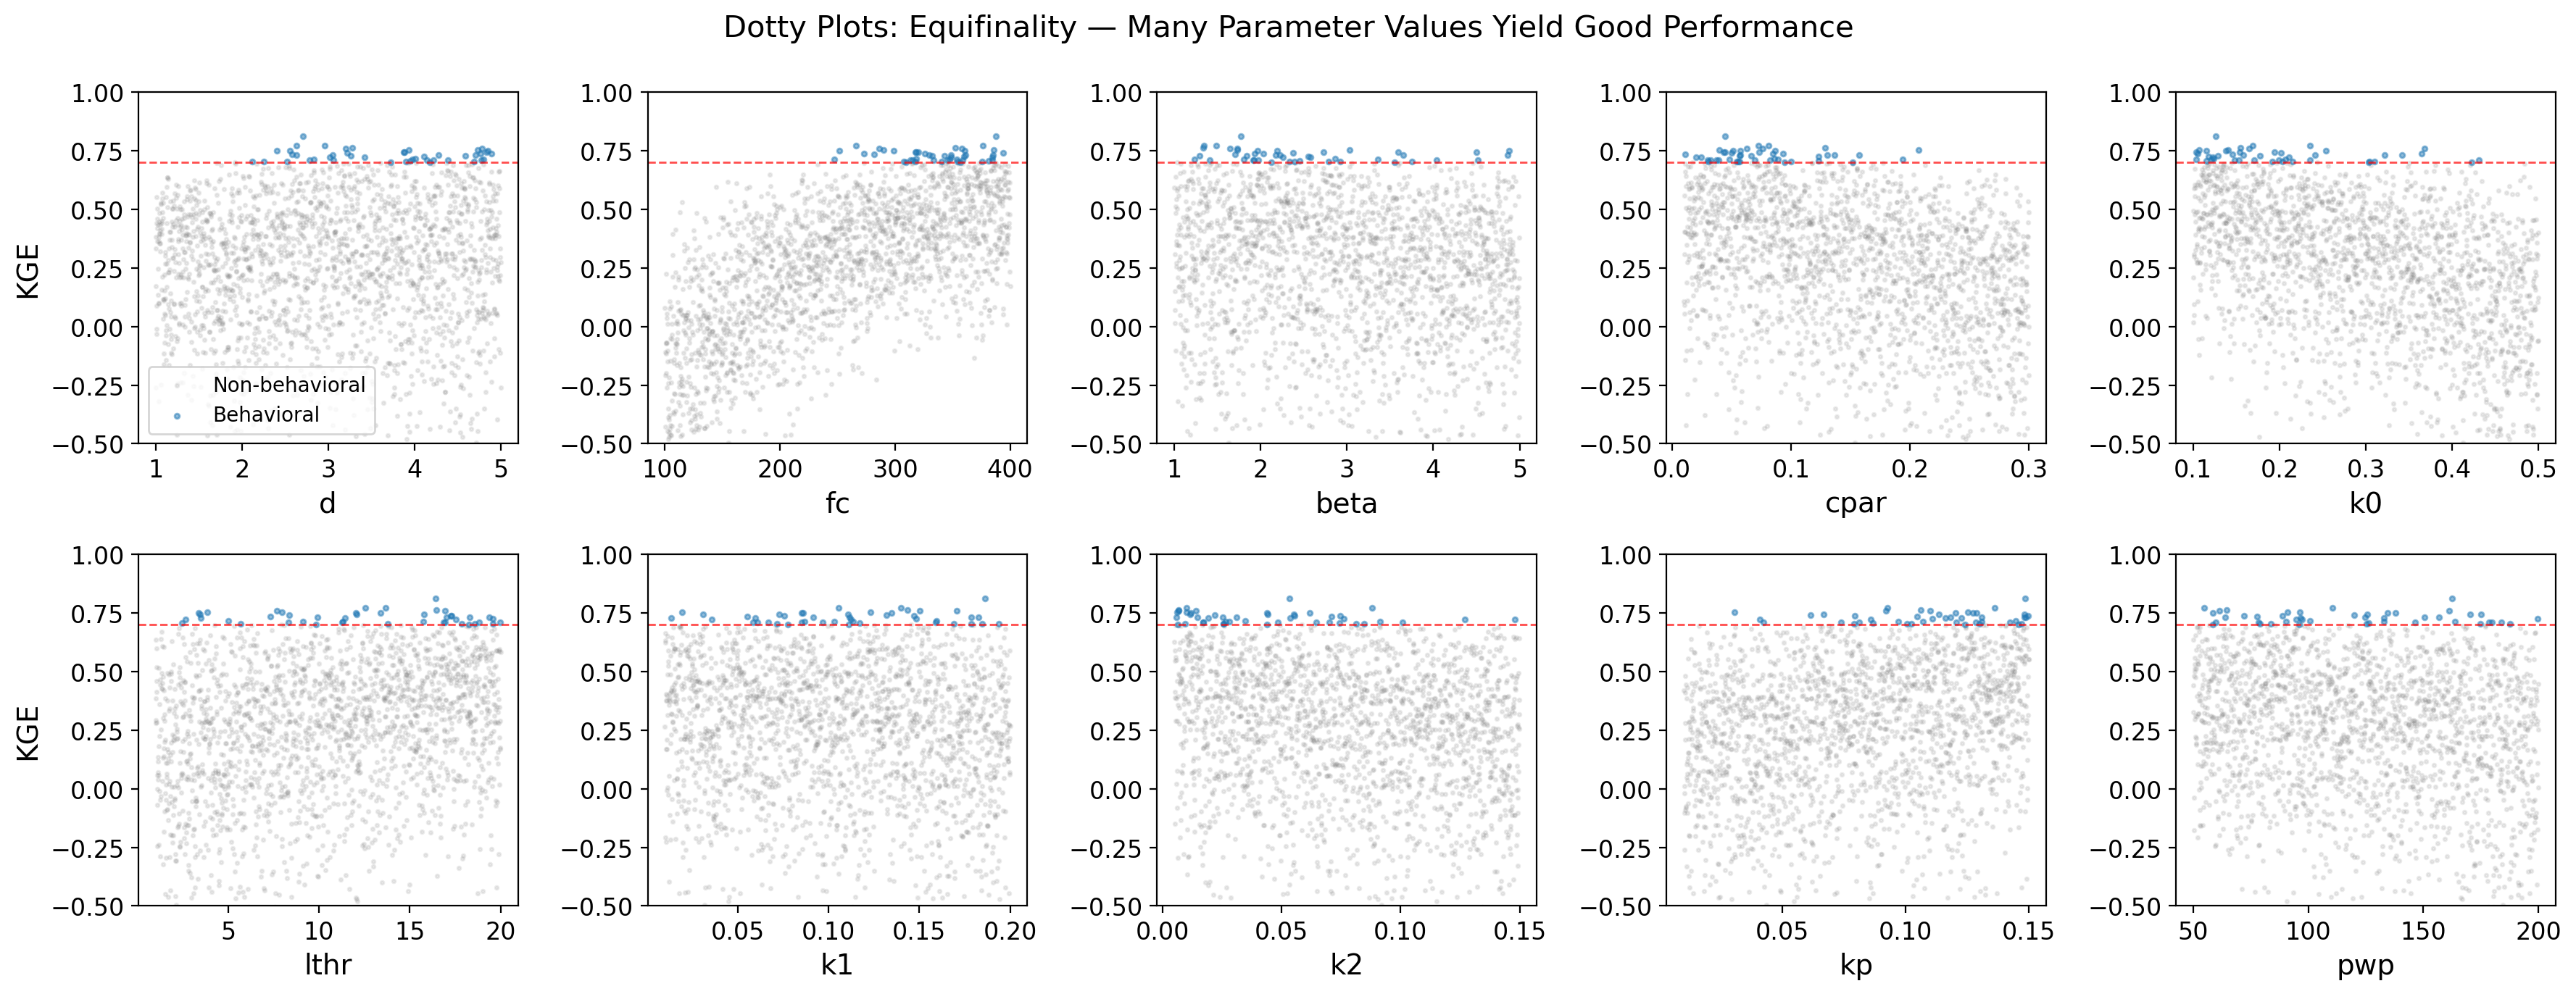

In [8]:
fig, axes = plt.subplots(2, 5, figsize=(18, 7))
axes = axes.flatten()

for j, pname in enumerate(param_names):
    ax = axes[j]
    ax.scatter(ensemble_params[~behavioral_mask, j], ensemble_kge[~behavioral_mask],
               s=3, alpha=0.15, c="gray", label="Non-behavioral")
    ax.scatter(ensemble_params[behavioral_mask, j], ensemble_kge[behavioral_mask],
               s=6, alpha=0.5, c="C0", label="Behavioral")
    ax.axhline(0.7, color="red", ls="--", lw=1, alpha=0.7)
    ax.set_xlabel(pname)
    if j % 5 == 0:
        ax.set_ylabel("KGE")
    ax.set_ylim(-0.5, 1.0)

axes[0].legend(fontsize=10, loc="lower left")
fig.suptitle("Dotty Plots: Equifinality — Many Parameter Values Yield Good Performance", fontsize=15)
plt.tight_layout()
plt.show()

### Top-3 Hydrographs & Parameters

The top-3 parameter sets by KGE all perform similarly well, yet produce visibly different
hydrographs. We also zoom in to **Water Year 1995** (Oct 1994 – Sep 1995) to see differences
in peak timing and recession behavior.

Top-3 parameter sets:
 Rank |  KGE(Q) |  KGE(1/Q) |       d |      fc |    beta |    cpar |      k0 |    lthr |      k1 |      k2 |      kp |     pwp
----------------------------------------------------------------------------------------------------------------------------------
  #1 |  0.8111 |   -3.4488 |   2.708 | 387.397 |   1.770 |   0.044 |   0.127 |  16.438 |   0.186 |   0.053 |   0.149 | 162.308
  #2 |  0.7704 |   -5.4666 |   2.636 | 376.281 |   1.482 |   0.081 |   0.169 |  12.548 |   0.105 |   0.088 |   0.136 | 110.402
  #3 |  0.7701 |    0.8263 |   2.963 | 266.017 |   1.339 |   0.073 |   0.235 |  13.667 |   0.140 |   0.010 |   0.093 |  54.855


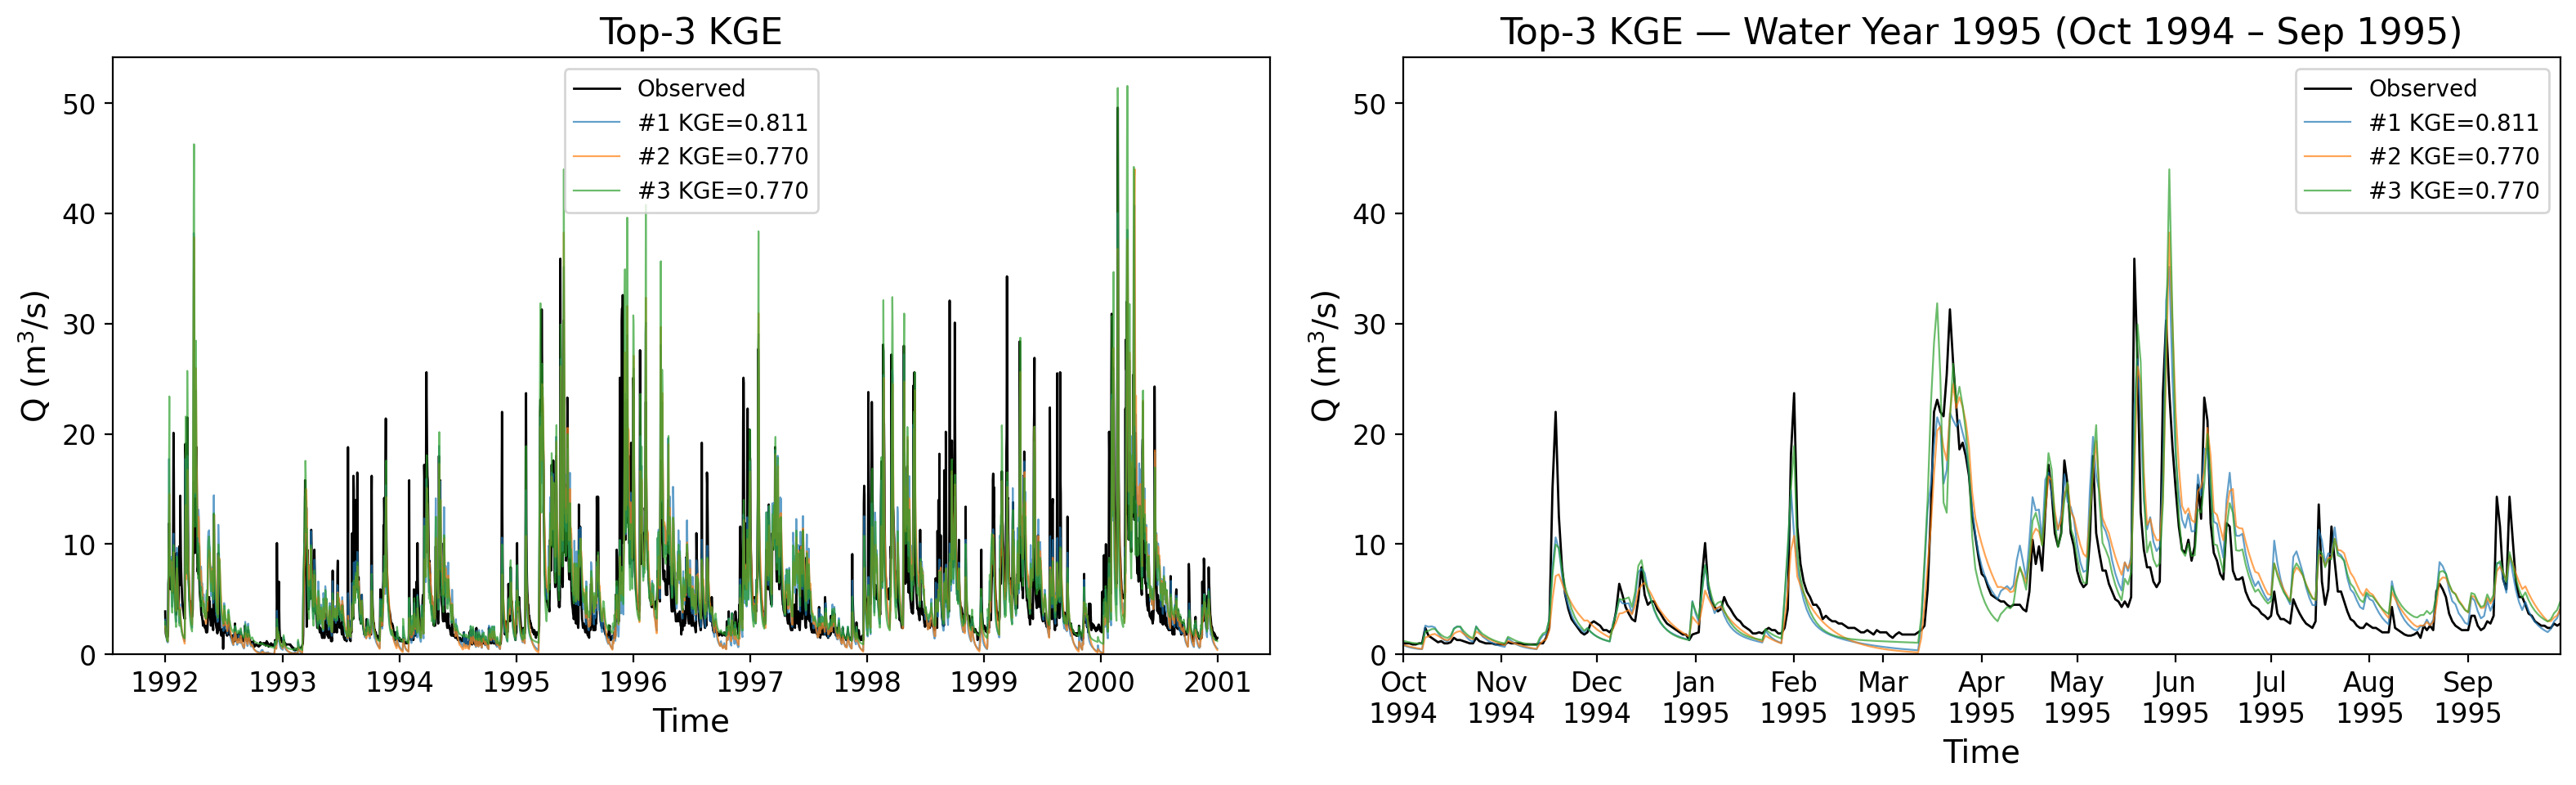

In [9]:
top3_idx = np.argsort(ensemble_kge)[-3:][::-1]

# Print parameters for the top 3
print("Top-3 parameter sets:")
print(f"{'Rank':>5} | {'KGE(Q)':>7} | {'KGE(1/Q)':>9} | " + " | ".join(f"{p:>7}" for p in param_names))
print("-" * 130)
for rank, idx in enumerate(top3_idx):
    vals = " | ".join(f"{v:7.3f}" for v in ensemble_params[idx])
    print(f"  #{rank+1} | {ensemble_kge[idx]:7.4f} | {ensemble_kge_inv[idx]:9.4f} | {vals}")

# Full period + WY 1995 zoom
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

time_post = forcing["Time"].values[WARMUP:]
obs_ref, _ = get_obs_sim(ensemble_Q[top3_idx[0]])

for ax_idx, (ax, title, xlim) in enumerate(zip(
    axes,
    ["Top-3 KGE", "Top-3 KGE — Water Year 1995 (Oct 1994 – Sep 1995)"],
    [None, (pd.Timestamp("1994-10-01"), pd.Timestamp("1995-09-30"))]
)):
    ax.plot(time_post[:len(obs_ref)], obs_ref, "k-", lw=1, label="Observed")
    for rank, idx in enumerate(top3_idx):
        _, sim_i = get_obs_sim(ensemble_Q[idx])
        ax.plot(time_post[:len(sim_i)], sim_i, lw=0.8, alpha=0.7,
                label=f"#{rank+1} KGE={ensemble_kge[idx]:.3f}")
    ax.set_xlabel("Time")
    ax.set_ylabel("Q (m$^3$/s)")
    ax.set_title(title)
    ax.legend(fontsize=10)
    ax.set_ylim(bottom=0)
    if xlim:
        ax.set_xlim(xlim)
        ax.xaxis.set_major_locator(plt.matplotlib.dates.MonthLocator())           
        ax.xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%b\n%Y'))


plt.tight_layout()
plt.show()

---
## Section 2: Local Optimization (Gradient-based)

**L-BFGS-B** is a quasi-Newton gradient-based optimizer that supports box constraints.
It uses finite-difference gradients to approximate the Hessian and converges quickly to a
*local* optimum. However, the result depends strongly on the **starting point**.

We run from 5 different random starting points to demonstrate this sensitivity.

| Property | Value |
|----------|-------|
| **Type** | Deterministic |
| **Scope** | Local |
| **Output** | Point estimate (one set of parameters) |
| **Parallelism** | Fully sequential per run; parallelizable across starts |
| **Model runs** | `nfev` + `callbacks` per start (see below) |

**Model run accounting**:
- **`nfev`** (number of function evaluations): scipy counts every call to the objective function,
  including the ~2×n_params calls per iteration for finite-difference gradient approximation.
- **`callbacks`**: we register a convergence callback that evaluates the KGE(Q) once per iteration
  for logging. Each callback = 1 additional model run.
- **`total_runs`** = `nfev` + `callbacks`.

In [11]:
np.random.seed(42)
n_starts = 5 # Start with 5 different points
bounds_list = [(param_bounds[p][0], param_bounds[p][1]) for p in param_names]

lbfgsb_results = []

for i in range(n_starts):
    x0 = lower_bounds + np.random.rand(n_params) * (upper_bounds - lower_bounds)

    history = []
    def callback(xk, history=history):
        val = 1.0 - kge_Q(xk)
        history.append(val)

    result = minimize(
        fun=lambda p: 1.0 - kge_Q(p),
        x0=x0,
        method="L-BFGS-B",
        bounds=bounds_list,
        callback=callback,
        options={"maxiter": 200, "ftol": 1e-8},
    )

    n_callbacks = len(history)
    total_runs = result.nfev + n_callbacks
    final_kge = 1.0 - result.fun
    final_kge_inv = kge_invQ(result.x)  # also report KGE(1/Q)
    lbfgsb_results.append({
        "start_idx": i,
        "x0": x0.copy(),
        "params": result.x.copy(),
        "kge": final_kge,
        "kge_inv": final_kge_inv,
        "nfev": result.nfev,
        "n_callbacks": n_callbacks,
        "total_runs": total_runs,
        "history": [1.0 - h for h in history],
    })
    print(f"Start {i+1}: KGE(Q)={final_kge:.4f}, KGE(1/Q)={final_kge_inv:.4f}  (nfev={result.nfev}, callbacks={n_callbacks}, total={total_runs})")

best_local = max(lbfgsb_results, key=lambda r: r["kge"])
total_all_starts = sum(r["total_runs"] for r in lbfgsb_results)
print(f"\nBest local optimum: KGE(Q)={best_local['kge']:.4f}, associated KGE(1/Q)={best_local['kge_inv']:.4f}")
print(f"Total model runs across all 5 starts: {total_all_starts}")

Start 1: KGE(Q)=0.8150, KGE(1/Q)=0.7558  (nfev=726, callbacks=56, total=782)
Start 2: KGE(Q)=0.8258, KGE(1/Q)=0.5576  (nfev=1001, callbacks=73, total=1074)
Start 3: KGE(Q)=0.8216, KGE(1/Q)=0.5797  (nfev=638, callbacks=49, total=687)
Start 4: KGE(Q)=0.8279, KGE(1/Q)=0.8289  (nfev=1265, callbacks=90, total=1355)
Start 5: KGE(Q)=0.8272, KGE(1/Q)=0.7259  (nfev=825, callbacks=61, total=886)

Best local optimum: KGE(Q)=0.8279, associated KGE(1/Q)=0.8289
Total model runs across all 5 starts: 4784


### Convergence Curves & Updated Hydrograph

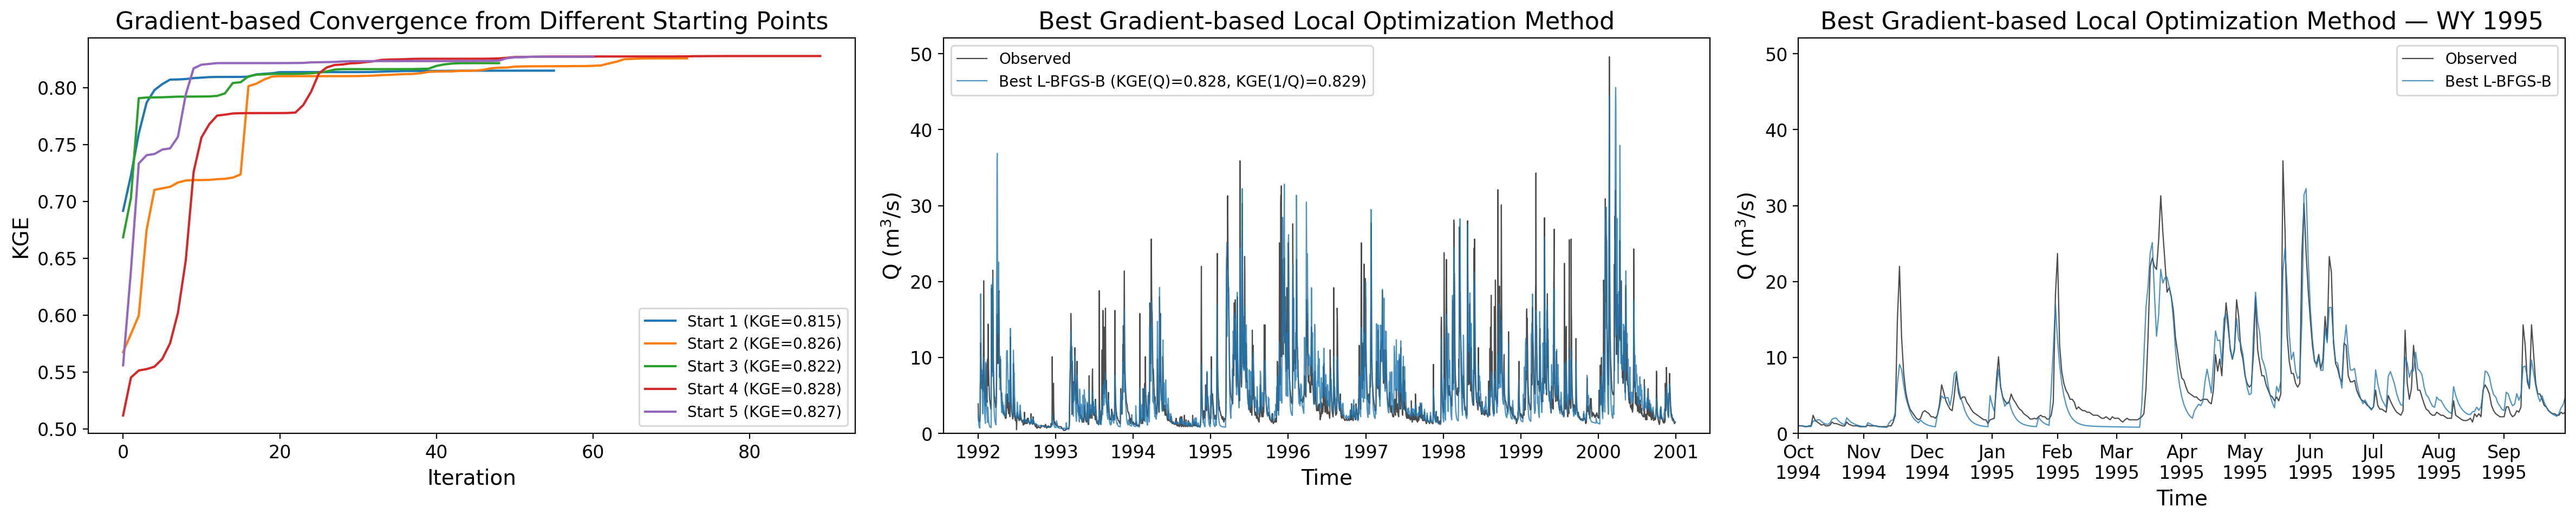

In [12]:
fig, axes = plt.subplots(1, 3, figsize=(24, 5))

ax = axes[0]
for r in lbfgsb_results:
    ax.plot(r["history"], label=f"Start {r['start_idx']+1} (KGE={r['kge']:.3f})")
ax.set_xlabel("Iteration")
ax.set_ylabel("KGE")
ax.set_title("Gradient-based Convergence from Different Starting Points")
ax.legend(fontsize=10)

Q_best = run_model(best_local["params"])
obs, sim = get_obs_sim(Q_best)
time_post = forcing["Time"].values[WARMUP:][:len(obs)]

ax = axes[1]
ax.plot(time_post, obs, "k-", lw=0.8, alpha=0.7, label="Observed")
ax.plot(time_post, sim, "C0-", lw=0.8, alpha=0.8,
        label=f"Best L-BFGS-B (KGE(Q)={best_local['kge']:.3f}, KGE(1/Q)={best_local['kge_inv']:.3f})")
ax.set_xlabel("Time")
ax.set_ylabel("Q (m$^3$/s)")
ax.set_title("Best Gradient-based Local Optimization Method")
ax.legend(fontsize=10)
ax.set_ylim(bottom=0)

ax = axes[2]
ax.plot(time_post, obs, "k-", lw=0.8, alpha=0.7, label="Observed")
ax.plot(time_post, sim, "C0-", lw=0.8, alpha=0.8, label="Best L-BFGS-B")
ax.set_xlim(pd.Timestamp("1994-10-01"), pd.Timestamp("1995-09-30"))
ax.xaxis.set_major_locator(plt.matplotlib.dates.MonthLocator())           
ax.xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%b\n%Y'))

ax.set_xlabel("Time")
ax.set_ylabel("Q (m$^3$/s)")
ax.set_title("Best Gradient-based Local Optimization Method — WY 1995")
ax.legend(fontsize=10)
ax.set_ylim(bottom=0)

plt.tight_layout()
plt.show()

### Parameter Table

In [13]:
print(f"{'Start':>6} | {'KGE(Q)':>7} | {'KGE(1/Q)':>9} | {'nfev':>6} | {'total':>6} | " + " | ".join(f"{p:>7}" for p in param_names))
print("-" * 150)
for r in lbfgsb_results:
    vals = " | ".join(f"{v:7.3f}" for v in r["params"])
    print(f"{r['start_idx']+1:>6} | {r['kge']:7.4f} | {r['kge_inv']:9.4f} | {r['nfev']:>6} | {r['total_runs']:>6} | {vals}")

 Start |  KGE(Q) |  KGE(1/Q) |   nfev |  total |       d |      fc |    beta |    cpar |      k0 |    lthr |      k1 |      k2 |      kp |     pwp
------------------------------------------------------------------------------------------------------------------------------------------------------
     1 |  0.8150 |    0.7558 |    726 |    782 |   2.833 | 385.162 |   2.239 |   0.062 |   0.100 |   3.792 |   0.176 |   0.005 |   0.124 | 156.267
     2 |  0.8258 |    0.5576 |   1001 |   1074 |   3.071 | 392.759 |   1.534 |   0.064 |   0.100 |  20.000 |   0.200 |   0.005 |   0.059 |  92.556
     3 |  0.8216 |    0.5797 |    638 |    687 |   2.775 | 143.170 |   3.348 |   0.010 |   0.100 |  20.000 |   0.148 |   0.005 |   0.150 |  55.893
     4 |  0.8279 |    0.8289 |   1265 |   1355 |   2.984 | 292.901 |   1.623 |   0.061 |   0.100 |  20.000 |   0.196 |   0.005 |   0.096 |  50.000
     5 |  0.8272 |    0.7259 |    825 |    886 |   2.954 | 248.593 |   2.732 |   0.059 |   0.100 |  20.000 |   0.1

**Q: What have you noticed from these 5 local optimization methods? Can you think of ways to improve the KGE(Q) based on what you noticed? Hint: Prior distributions**

---
## Section 3: Global Optimization — Particle Swarm Optimization (PSO)

  **Particle Swarm Optimization (PSO)** is a population-based global optimization method inspired by collective behavior (e.g., bird flocking). A "swarm" of candidate solutions
   (particles) moves through parameter space. Each particle's velocity is updated at every iteration using three components:
  - **Inertia**: continue in the current direction (controlled by weight `w`)
  - **Cognitive pull**: move toward the particle's own best-found position
  (scaled by `c1 × r1`)
  - **Social pull**: move toward the swarm's global best position (scaled by `c2 × r2`)

  where `r1, r2 ~ Uniform(0,1)` are random each iteration, making PSO
  **stochastic** — different
  runs with different seeds can produce different results, even though only one
  best solution
  is returned.


| Property | Value |
|----------|-------|
| **Type** | Deterministic |
| **Scope** | Global |
| **Output** | Point estimate (one set of parameters) |
| **Parallelism** | Iter-sequential + within-iteration parallelizable |
| **Model runs** | 30 particles × 100 iterations = 3,000 |

In [14]:
import pyswarms as ps

def pso_objective(particles):
    """Evaluate 1-KGE for a batch of particles. Shape: (n_particles, n_params) -> (n_particles,)."""
    costs = np.zeros(particles.shape[0])
    for i in range(particles.shape[0]):
        costs[i] = 1.0 - kge_Q(particles[i])
    return costs

options = {"c1": 1.5, "c2": 1.5, "w": 0.7}

optimizer = ps.single.GlobalBestPSO(
    n_particles=30,
    dimensions=n_params,
    options=options,
    bounds=(lower_bounds, upper_bounds),
)

best_cost, best_pos = optimizer.optimize(pso_objective, iters=100, verbose=False)
pso_kge = 1.0 - best_cost
pso_kge_inv = kge_invQ(best_pos)

print(f"PSO best KGE(Q):   {pso_kge:.4f}")
print(f"PSO best KGE(Q) associated KGE(1/Q): {pso_kge_inv:.4f}")
print(f"Total model evaluations: {30 * 100}")

# Print final parameters
print(f"\nPSO final parameters:")
for pname, val in zip(param_names, best_pos):
    print(f"  {pname:>5} = {val:.4f}")

PSO best KGE(Q):   0.8045
PSO best KGE(Q) associated KGE(1/Q): 0.7578
Total model evaluations: 3000

PSO final parameters:
      d = 4.4918
     fc = 377.0907
   beta = 1.8398
   cpar = 0.0631
     k0 = 0.1168
   lthr = 3.5029
     k1 = 0.1267
     k2 = 0.0050
     kp = 0.0970
    pwp = 111.8335


### PSO Cost History & Updated Hydrograph

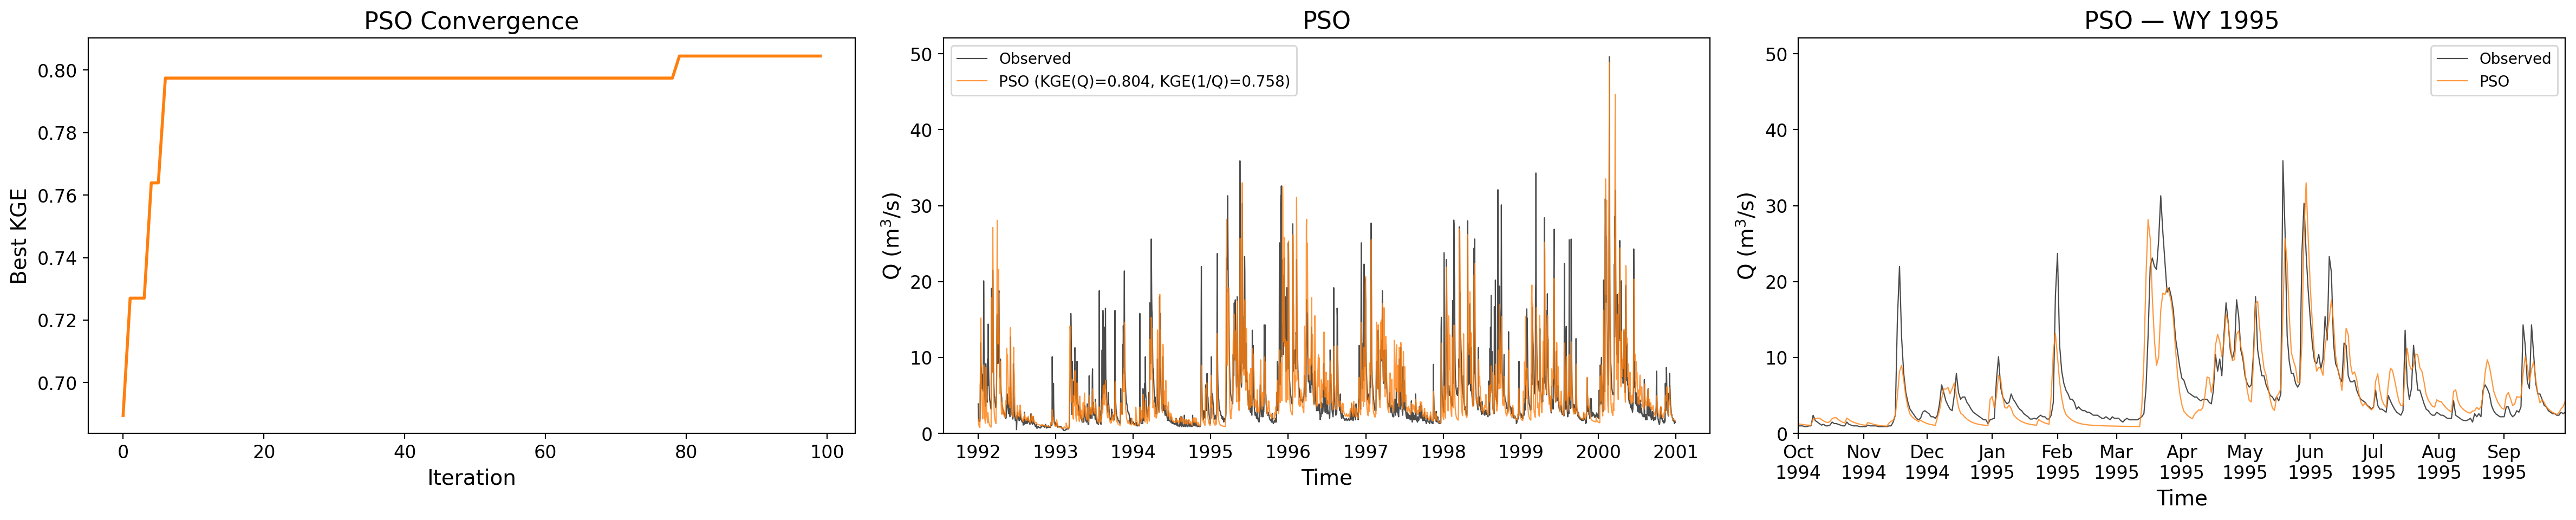

In [15]:
fig, axes = plt.subplots(1, 3, figsize=(24, 5))

ax = axes[0]
cost_history = [1.0 - c for c in optimizer.cost_history]
ax.plot(cost_history, "C1-", lw=2)
ax.set_xlabel("Iteration")
ax.set_ylabel("Best KGE")
ax.set_title("PSO Convergence")

Q_pso = run_model(best_pos)
obs_pso, sim_pso = get_obs_sim(Q_pso)
time_post = forcing["Time"].values[WARMUP:][:len(obs_pso)]
obs_lb, sim_lb = get_obs_sim(run_model(best_local["params"]))

ax = axes[1]
ax.plot(time_post, obs_pso, "k-", lw=0.8, alpha=0.7, label="Observed")
ax.plot(time_post, sim_pso, "C1-", lw=0.8, alpha=0.8,
        label=f"PSO (KGE(Q)={pso_kge:.3f}, KGE(1/Q)={pso_kge_inv:.3f})")
ax.set_xlabel("Time")
ax.set_ylabel("Q (m$^3$/s)")
ax.set_title("PSO")
ax.legend(fontsize=10)
ax.set_ylim(bottom=0)

ax = axes[2]
ax.plot(time_post, obs_pso, "k-", lw=0.8, alpha=0.7, label="Observed")
ax.plot(time_post, sim_pso, "C1-", lw=0.8, alpha=0.8, label="PSO")
ax.set_xlim(pd.Timestamp("1994-10-01"), pd.Timestamp("1995-09-30"))
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=2))
ax.xaxis.set_major_formatter(mdates.DateFormatter("%b\n%y"))
ax.xaxis.set_major_locator(plt.matplotlib.dates.MonthLocator())           
ax.xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%b\n%Y'))
ax.set_xlabel("Time")
ax.set_ylabel("Q (m$^3$/s)")
ax.set_title("PSO — WY 1995")
ax.legend(fontsize=10)
ax.set_ylim(bottom=0)

plt.tight_layout()
plt.show()

---
## Section 4: Multi-Objective Optimization

A single objective (KGE on Q) tends to favor high-flow performance. By adding a
second objective — **KGE on 1/Q** — we can also emphasize low-flow accuracy.
The **Pareto front** shows solutions where no objective can be improved without
worsening the other.

We trace the Pareto front using **weighted-sum L-BFGS-B optimization** for different
weight combinations.

In [22]:
weights = [0.0, 0.25, 0.5, 0.75,  1.0]
weighted_results = []

for w in weights:
    def weighted_obj(params, w=w):
        k1 = kge_Q(params)
        k2 = kge_invQ(params)
        return -(w * k1 + (1 - w) * k2)

    # Start from PSO best
    res = minimize(weighted_obj, x0=best_pos, method="L-BFGS-B",
                   bounds=bounds_list, options={"maxiter": 100})
    k1 = kge_Q(res.x)
    k2 = kge_invQ(res.x)
    weighted_results.append({"w": w, "kge_Q": k1, "kge_invQ": k2, "params": res.x})
    print(f"w={w:.2f}: KGE(Q)={k1:.4f}, KGE(1/Q)={k2:.4f}")

w=0.00: KGE(Q)=0.7530, KGE(1/Q)=0.8886
w=0.25: KGE(Q)=0.7662, KGE(1/Q)=0.8865
w=0.50: KGE(Q)=0.7937, KGE(1/Q)=0.8762
w=0.75: KGE(Q)=0.8150, KGE(1/Q)=0.8410
w=1.00: KGE(Q)=0.8294, KGE(1/Q)=0.6935


### Pareto Front & Hydrograph Comparison

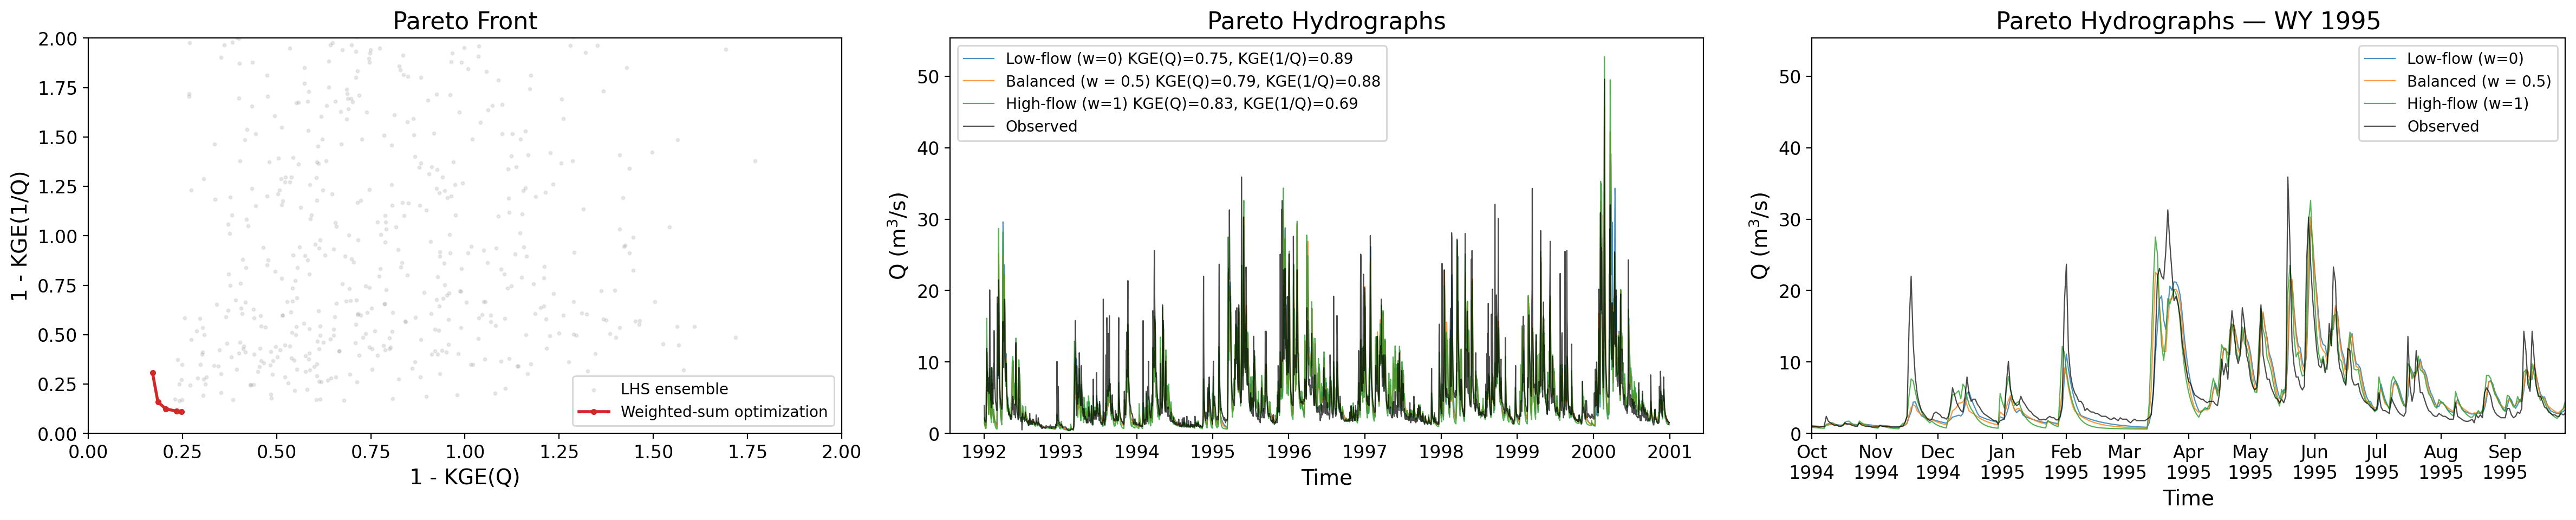

In [20]:
fig, axes = plt.subplots(1, 3, figsize=(24, 5))

# Pareto front with 1-KGE axes (minimization)
ax = axes[0]
valid = np.isfinite(ensemble_kge) & np.isfinite(ensemble_kge_inv)
ax.scatter(1 - ensemble_kge[valid], 1 - ensemble_kge_inv[valid],
           s=4, alpha=0.15, c="gray", label="LHS ensemble")

pareto_kge_Q = np.array([r["kge_Q"] for r in weighted_results])
pareto_kge_inv = np.array([r["kge_invQ"] for r in weighted_results])
sort_idx = np.argsort(1 - pareto_kge_Q)
ax.plot((1 - pareto_kge_Q)[sort_idx], (1 - pareto_kge_inv)[sort_idx],
        "C3o-", markersize=3, lw=2, label="Weighted-sum optimization", zorder=5)

ax.set_xlabel("1 - KGE(Q)")
ax.set_ylabel("1 - KGE(1/Q)")
ax.set_xlim(0, 2)
ax.set_ylim(0, 2)
ax.set_title("Pareto Front")
ax.legend(fontsize=10)

# Hydrographs - full period
ax = axes[1]
time_post = forcing["Time"].values[WARMUP:]
for wr, label, color in [
    (weighted_results[0], "Low-flow (w=0)", "C1"),
    (weighted_results[len(weights)//2], "Balanced (w = 0.5)", "C2"),
    (weighted_results[-1], "High-flow (w=1)", "C0"),
]:
    Q_sim = run_model(wr["params"])
    obs_i, sim_i = get_obs_sim(Q_sim)
    ax.plot(time_post[:len(sim_i)], sim_i, lw=0.8, alpha=0.8,
            label=f"{label} KGE(Q)={wr['kge_Q']:.2f}, KGE(1/Q)={wr['kge_invQ']:.2f}")
ax.plot(time_post[:len(obs_i)], obs_i, "k-", lw=0.8, alpha=0.7, label="Observed")
ax.set_xlabel("Time")
ax.set_ylabel("Q (m$^3$/s)")
ax.set_title("Pareto Hydrographs")
ax.legend(fontsize=10)
ax.set_ylim(bottom=0)

# WY 1995 zoom
ax = axes[2]
for wr, label, color in [
    (weighted_results[0], "Low-flow (w=0)", "C1"),
    (weighted_results[len(weights)//2], "Balanced (w = 0.5)", "C2"),
    (weighted_results[-1], "High-flow (w=1)", "C0"),
]:
    Q_sim = run_model(wr["params"])
    obs_i, sim_i = get_obs_sim(Q_sim)
    ax.plot(time_post[:len(sim_i)], sim_i, lw=0.8, alpha=0.8, label=label)
ax.plot(time_post[:len(obs_i)], obs_i, "k-", lw=0.8, alpha=0.7, label="Observed")
ax.set_xlim(pd.Timestamp("1994-10-01"), pd.Timestamp("1995-09-30"))
ax.set_xlabel("Time")
ax.set_ylabel("Q (m$^3$/s)")
ax.set_title("Pareto Hydrographs — WY 1995")
ax.xaxis.set_major_locator(plt.matplotlib.dates.MonthLocator())           
ax.xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%b\n%Y'))
ax.legend(fontsize=10)
ax.set_ylim(bottom=0)

plt.tight_layout()
plt.show()

### Parameter Comparison for different weights

In [23]:
print(f"{'w':>5} | {'KGE(Q)':>7} | {'KGE(1/Q)':>9} | " + " | ".join(f"{p:>7}" for p in param_names))
print("-" * 140)
for wr in weighted_results:
    vals = " | ".join(f"{v:7.3f}" for v in wr["params"])
    print(f"{wr['w']:5.2f} | {wr['kge_Q']:7.4f} | {wr['kge_invQ']:9.4f} | {vals}")

    w |  KGE(Q) |  KGE(1/Q) |       d |      fc |    beta |    cpar |      k0 |    lthr |      k1 |      k2 |      kp |     pwp
--------------------------------------------------------------------------------------------------------------------------------------------
 0.00 |  0.7530 |    0.8886 |   2.911 | 376.905 |   2.064 |   0.079 |   0.120 |   8.352 |   0.047 |   0.005 |   0.028 | 111.926
 0.25 |  0.7662 |    0.8865 |   3.061 | 376.866 |   2.107 |   0.084 |   0.123 |   7.742 |   0.058 |   0.005 |   0.034 | 111.972
 0.50 |  0.7937 |    0.8762 |   4.948 | 376.778 |   2.331 |   0.090 |   0.109 |   7.839 |   0.075 |   0.005 |   0.040 | 112.013
 0.75 |  0.8150 |    0.8410 |   4.396 | 376.616 |   2.202 |   0.086 |   0.100 |   8.997 |   0.129 |   0.005 |   0.064 | 112.077
 1.00 |  0.8294 |    0.6935 |   4.396 | 321.552 |   1.615 |   0.066 |   0.100 |  20.000 |   0.175 |   0.005 |   0.062 |  50.000


---
## Section 5: ABC (Approximate Bayesian Computation)

**Rejection-ABC** is a likelihood-free inference method:
1. Sample parameters from the prior distribution
2. Run the model and compute a **distance** between simulated and observed summary statistics
3. Accept samples where `distance < epsilon` (tolerance)
4. Accepted samples have **EQUAL WEIGHT** — this is standard rejection sampling

| Property | Value |
|----------|-------|
| **Type** | Stochastic |
| **Scope** | Global |
| **Output** | Formal approximate posterior (equal-weight samples) |
| **Parallelism** | Fully parallel |
| **Model runs** | 2,000 (reused from Section 1) |

As ε → 0 and N → ∞, the ABC posterior converges to the true Bayesian posterior.
The distance metric here is 1 - KGE(Q).

In [34]:
# Reuse the 2000 LHS samples from Section 1
abc_params = ensemble_params.copy()
N_ABC = N_ENSEMBLE
abc_Q = ensemble_Q.copy()

# Distance 1: based on KGE(Q) only
abc_dist_Q = 1.0 - ensemble_kge.copy()

# Distance 2: based on combined 0.5*KGE(Q) + 0.5*KGE(1/Q)
abc_dist_combined = 1.0 - (0.5 * ensemble_kge + 0.5 * ensemble_kge_inv)

print(f"Total ABC samples: {N_ABC} (reused from Section 1)")
print(f"\nDistance d1 = 1-KGE(Q):                         min={np.nanmin(abc_dist_Q):.4f}, median={np.nanmedian(abc_dist_Q):.4f}")
print(f"Distance d2 = 1-(0.5*KGE(Q)+0.5*KGE(1/Q)):     min={np.nanmin(abc_dist_combined):.4f}, median={np.nanmedian(abc_dist_combined):.4f}")

Total ABC samples: 2000 (reused from Section 1)

Distance d1 = 1-KGE(Q):                         min=0.1889, median=0.7145
Distance d2 = 1-(0.5*KGE(Q)+0.5*KGE(1/Q)):     min=0.2018, median=3.2756


### ABC Acceptance

We apply two distance criteria with fixed tolerances:
- **d1 = 1 - KGE(Q)**: accept if d1 < 0.3 (i.e., KGE(Q) > 0.7)
- **d2 = 1 - (0.5·KGE(Q) + 0.5·KGE(1/Q))**: accept if d2 < 0.4

All accepted samples have **equal weight** (standard rejection sampling).

In [35]:
abc_kge_Q_vals = ensemble_kge.copy()
abc_kge_inv = ensemble_kge_inv.copy()

# --- d1 = 1 - KGE(Q), accept if d1 < 0.3 ---
eps_d1 = 0.3
accepted_d1 = abc_dist_Q < eps_d1
n_acc_d1 = np.sum(accepted_d1)
abc_results_Q = {
    "epsilon": eps_d1, "accepted": accepted_d1,
    "n_accepted": n_acc_d1, "params": abc_params[accepted_d1],
}
print(f"d1 = 1-KGE(Q) < {eps_d1}: {n_acc_d1} accepted out of {N_ABC}")
print(f"  mean KGE(Q)   = {np.nanmean(abc_kge_Q_vals[accepted_d1]):.4f}")
print(f"  mean KGE(1/Q) = {np.nanmean(abc_kge_inv[accepted_d1]):.4f}")

# --- d2 = 1 - (0.5*KGE(Q) + 0.5*KGE(1/Q)), accept if d2 < 0.4 ---
eps_d2 = 0.4
accepted_d2 = abc_dist_combined < eps_d2
n_acc_d2 = np.sum(accepted_d2)
abc_results_comb = {
    "epsilon": eps_d2, "accepted": accepted_d2,
    "n_accepted": n_acc_d2, "params": abc_params[accepted_d2],
}
print(f"\nd2 = 1-(0.5*KGE(Q)+0.5*KGE(1/Q)) < {eps_d2}: {n_acc_d2} accepted out of {N_ABC}")
print(f"  mean KGE(Q)   = {np.nanmean(abc_kge_Q_vals[accepted_d2]):.4f}")
print(f"  mean KGE(1/Q) = {np.nanmean(abc_kge_inv[accepted_d2]):.4f}")

d1 = 1-KGE(Q) < 0.3: 45 accepted out of 2000
  mean KGE(Q)   = 0.7300
  mean KGE(1/Q) = -4.2292

d2 = 1-(0.5*KGE(Q)+0.5*KGE(1/Q)) < 0.4: 37 accepted out of 2000
  mean KGE(Q)   = 0.6346
  mean KGE(1/Q) = 0.7219


### ABC Visualizations

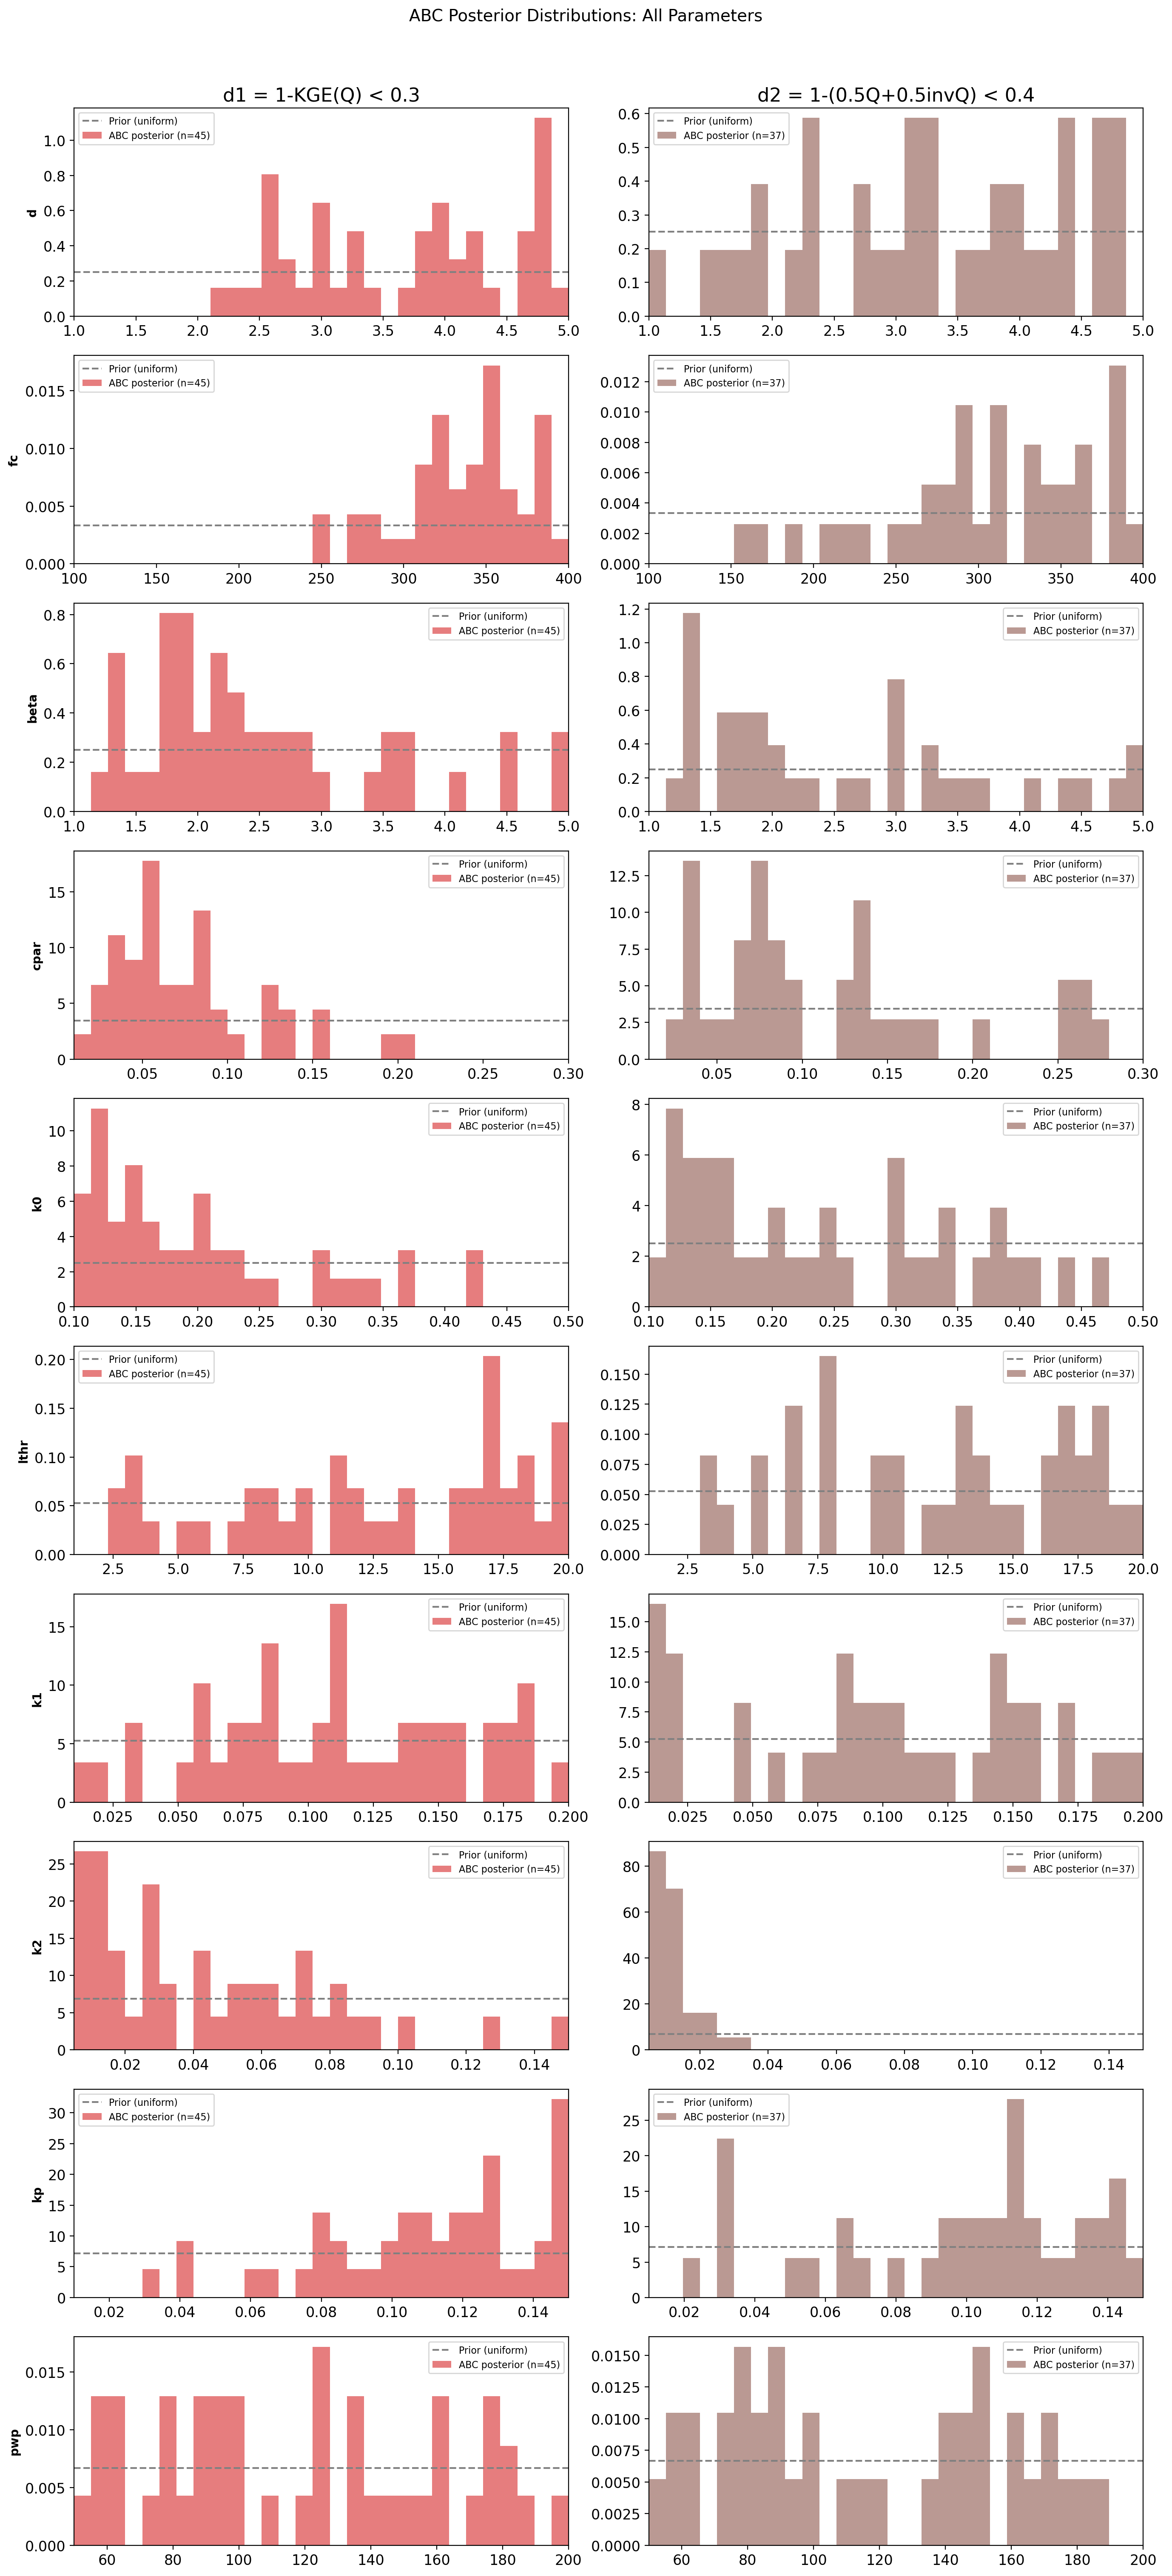

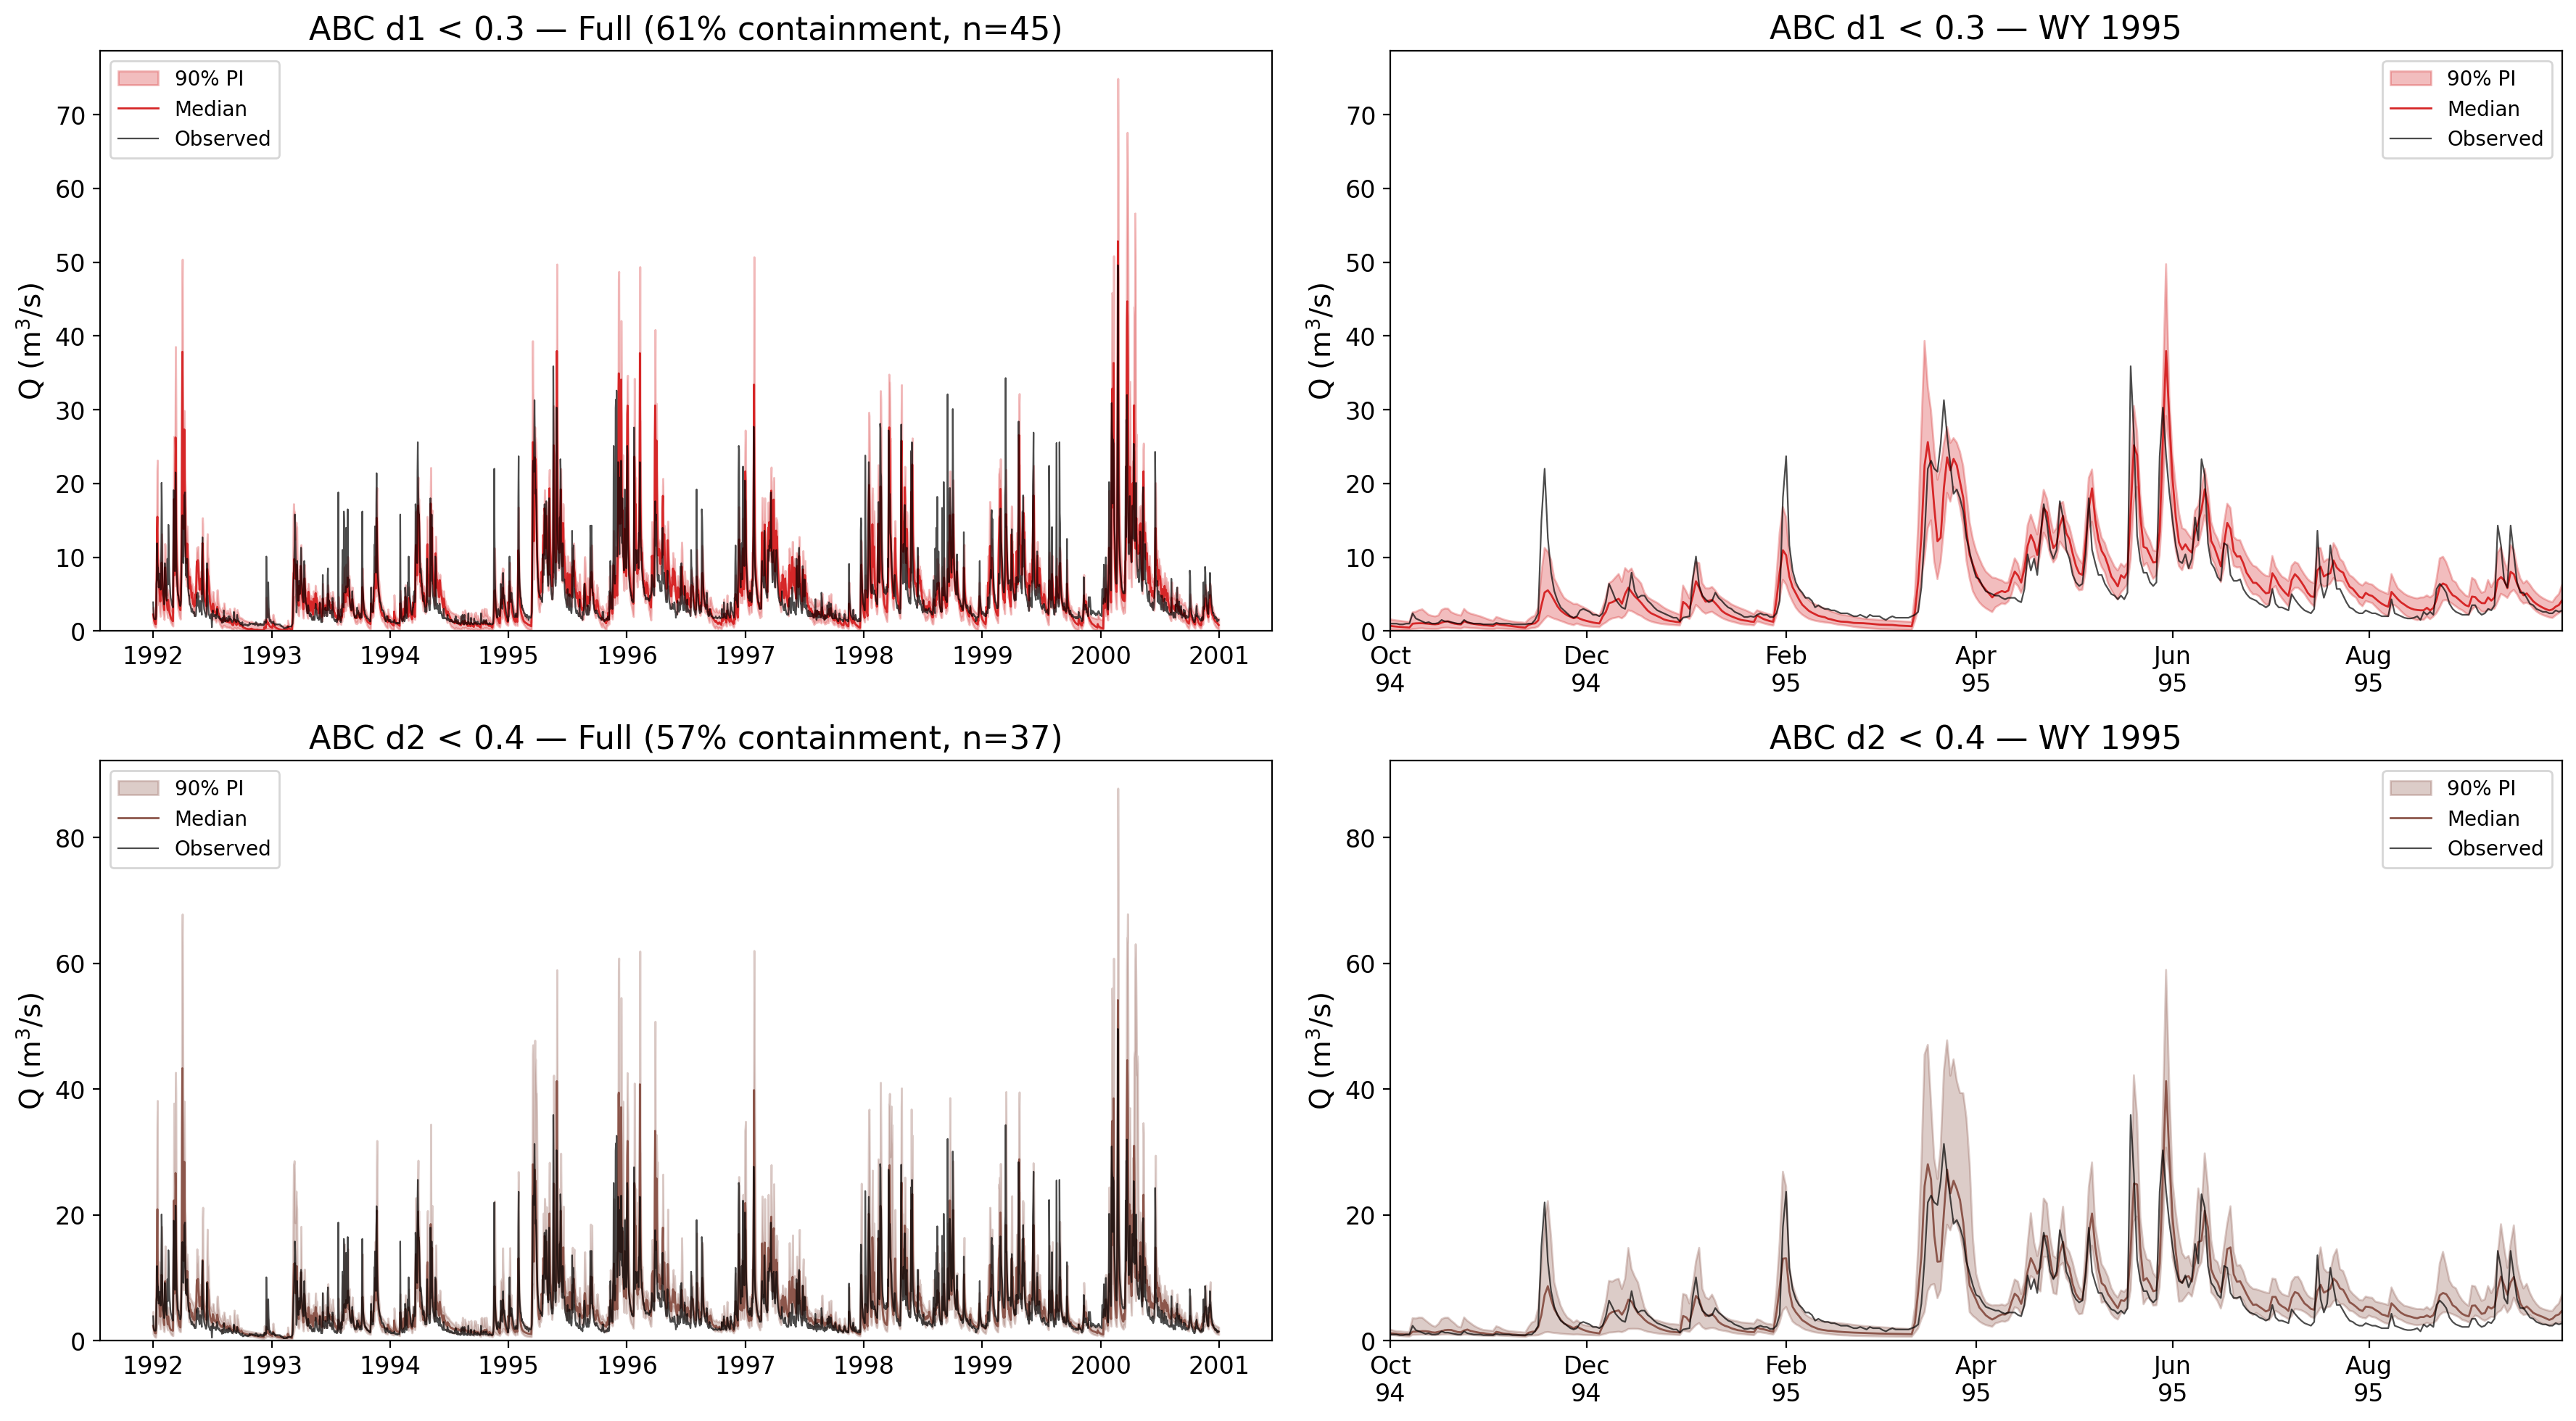

In [37]:
# --- ABC Posterior Distributions (all parameters) ---
fig, axes = plt.subplots(n_params, 2, figsize=(14, 3 * n_params))

for j, pname in enumerate(param_names):
    lo, hi = lower_bounds[j], upper_bounds[j]
    bins = np.linspace(lo, hi, 30)
    uniform_density = 1.0 / (hi - lo)

    # d1 posterior
    ax = axes[j, 0]
    ax.axhline(uniform_density, color="gray", ls="--", lw=1.5, label="Prior (uniform)")
    ax.hist(abc_results_Q["params"][:, j], bins=bins, alpha=0.6, density=True,
            color="C3", label=f"ABC posterior (n={abc_results_Q['n_accepted']})")
    ax.set_ylabel(pname, fontsize=10, fontweight="bold")
    ax.set_xlim(lo, hi)
    if j == 0:
        ax.set_title(f"d1 = 1-KGE(Q) < {eps_d1}")
    ax.legend(fontsize=8)

    # d2 posterior
    ax = axes[j, 1]
    ax.axhline(uniform_density, color="gray", ls="--", lw=1.5, label="Prior (uniform)")
    ax.hist(abc_results_comb["params"][:, j], bins=bins, alpha=0.6, density=True,
            color="C5", label=f"ABC posterior (n={abc_results_comb['n_accepted']})")
    ax.set_xlim(lo, hi)
    if j == 0:
        ax.set_title(f"d2 = 1-(0.5Q+0.5invQ) < {eps_d2}")
    ax.legend(fontsize=8)

plt.suptitle("ABC Posterior Distributions: All Parameters", fontsize=14, y=1.01)
plt.tight_layout()
plt.show()

# --- ABC Prediction Intervals ---
fig, axes = plt.subplots(2, 2, figsize=(18, 10))

obs_ref, _ = get_obs_sim(ensemble_Q[0])
n_obs = len(obs_ref)
time_post = forcing["Time"].values[WARMUP:]

for row, (accepted, res, label, color) in enumerate([
    (accepted_d1, abc_results_Q, f"d1 < {eps_d1}", "C3"),
    (accepted_d2, abc_results_comb, f"d2 < {eps_d2}", "C5"),
]):
    Q_acc = abc_Q[accepted][:, WARMUP:]
    p5 = np.percentile(Q_acc, 5, axis=0)
    p50 = np.percentile(Q_acc, 50, axis=0)
    p95 = np.percentile(Q_acc, 95, axis=0)
    cont = np.sum((obs_ref >= p5[:n_obs]) & (obs_ref <= p95[:n_obs])) / n_obs * 100

    ax = axes[row, 0]
    ax.fill_between(time_post[:n_obs], p5[:n_obs], p95[:n_obs],
                    alpha=0.3, color=color, label="90% PI")
    ax.plot(time_post[:n_obs], p50[:n_obs], color=color, lw=1, label="Median")
    ax.plot(time_post[:n_obs], obs_ref, "k-", lw=0.8, alpha=0.7, label="Observed")
    ax.set_ylabel("Q (m$^3$/s)")
    ax.set_title(f"ABC {label} — Full ({cont:.0f}% containment, n={res['n_accepted']})")
    ax.legend(fontsize=10)
    ax.set_ylim(bottom=0)

    ax = axes[row, 1]
    ax.fill_between(time_post[:n_obs], p5[:n_obs], p95[:n_obs],
                    alpha=0.3, color=color, label="90% PI")
    ax.plot(time_post[:n_obs], p50[:n_obs], color=color, lw=1, label="Median")
    ax.plot(time_post[:n_obs], obs_ref, "k-", lw=0.8, alpha=0.7, label="Observed")
    ax.set_xlim(pd.Timestamp("1994-10-01"), pd.Timestamp("1995-09-30"))
    ax.xaxis.set_major_locator(mdates.MonthLocator(interval=2))
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%b\n%y"))
    ax.set_ylabel("Q (m$^3$/s)")
    ax.set_title(f"ABC {label} — WY 1995")
    ax.legend(fontsize=10)
    ax.set_ylim(bottom=0)

plt.tight_layout()
plt.show()

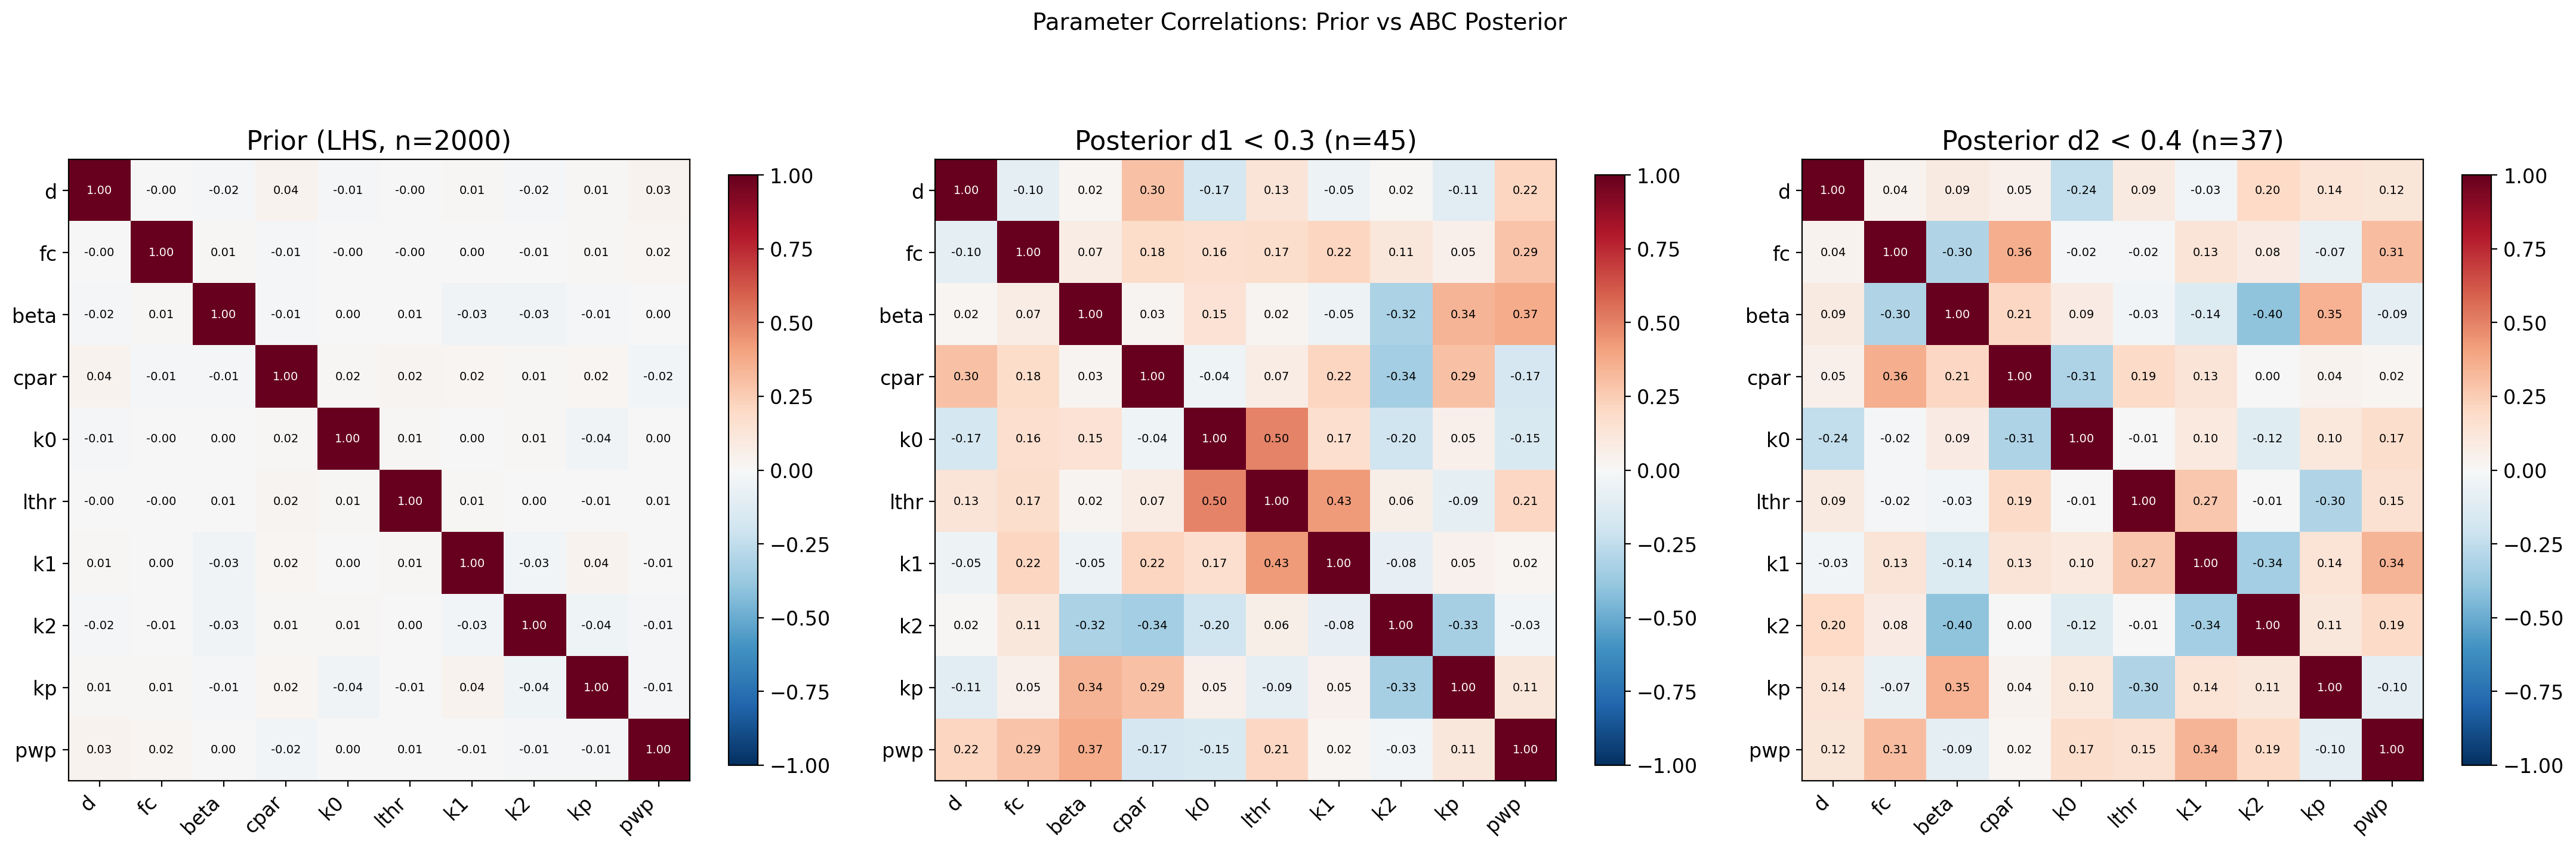

In [39]:
# --- ABC Parameter Correlations: Prior vs Posterior ---
fig, axes = plt.subplots(1, 3, figsize=(22, 7))

for ax, (params, label) in zip(axes, [
    (ensemble_params, "Prior (LHS, n=2000)"),
    (abc_results_Q["params"], f"Posterior d1 < {eps_d1} (n={abc_results_Q['n_accepted']})"),
    (abc_results_comb["params"], f"Posterior d2 < {eps_d2} (n={abc_results_comb['n_accepted']})"),
]):
    corr = np.corrcoef(params.T)
    im = ax.imshow(corr, cmap="RdBu_r", vmin=-1, vmax=1, aspect="equal")
    for i in range(n_params):
        for j in range(n_params):
            color = "white" if abs(corr[i, j]) > 0.6 else "black"
            ax.text(j, i, f"{corr[i, j]:.2f}", ha="center", va="center",
                    fontsize=7, color=color)
    ax.set_xticks(range(n_params))
    ax.set_xticklabels(param_names, rotation=45, ha="right")
    ax.set_yticks(range(n_params))
    ax.set_yticklabels(param_names)
    ax.set_title(label)
    plt.colorbar(im, ax=ax, shrink=0.8)

plt.suptitle("Parameter Correlations: Prior vs ABC Posterior", fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

---
## Section 6: GLUE (Generalized Likelihood Uncertainty Estimation)

**GLUE** (Beven & Binley, 1992) extends the ABC-style rejection idea with one key difference:
accepted samples are **WEIGHTED** by their likelihood value, rather than treated equally.

1. Sample many parameter sets from the prior
2. Run the model and compute a "likelihood" measure (here, KGE)
3. Reject parameter sets below a **behavioral threshold**
4. **Weight** the retained simulations by (KGE - threshold)
5. Compute weighted prediction intervals

| Property | Value |
|----------|-------|
| **Type** | Stochastic |
| **Scope** | Global |
| **Output** | Weighted pseudo-posterior |
| **Parallelism** | Fully parallel |
| **Model runs** | 2000 runs (reuses Section 1 ensemble) |

**Key difference from ABC**: In ABC, accepted samples have **equal weight**. In GLUE, accepted
samples are **weighted** by their performance measure. The "likelihood" in GLUE is informal —
not a proper statistical likelihood — and the threshold is subjective. GLUE has no convergence
guarantee to a true posterior.

In [66]:
# Reuse ensemble from Section 1
# Same acceptance criteria as ABC for direct comparison

GLUE_THRESH_1 = 1.0 - eps_d1   # 0.7
GLUE_THRESH_2 = 1.0 - eps_d2   # 0.6

# --- Criterion 1: KGE(Q) > GLUE_THRESH_1 ---
glue_behavioral = ensemble_kge > GLUE_THRESH_1
n_glue = np.sum(glue_behavioral)

# Three weighting schemes for criterion 1
glue_w1_equal = np.ones(n_glue) / n_glue                              # no weights (= ABC)
glue_w1_linear = (ensemble_kge[glue_behavioral] - GLUE_THRESH_1)       # KGE_i - 0.7
glue_w1_linear = glue_w1_linear / glue_w1_linear.sum()
glue_w1_best = np.zeros(n_glue)
glue_w1_best[np.argmax(ensemble_kge[glue_behavioral])] = 1.0  # all weight on best

# --- Criterion 2: 0.5*KGE(Q) + 0.5*KGE(1/Q) > GLUE_THRESH_2 ---
glue_combined_score = 0.5 * ensemble_kge + 0.5 * ensemble_kge_inv
glue_behavioral_comb = glue_combined_score > GLUE_THRESH_2
n_glue_comb = np.sum(glue_behavioral_comb)

# Three weighting schemes for criterion 2
glue_w2_equal = np.ones(n_glue_comb) / n_glue_comb
glue_w2_linear = (glue_combined_score[glue_behavioral_comb] - GLUE_THRESH_2)
glue_w2_linear = glue_w2_linear / glue_w2_linear.sum()
glue_w2_best = np.zeros(n_glue_comb)
glue_w2_best[np.argmax(glue_combined_score[glue_behavioral_comb])] = 1.0

# Keep backward-compatible names
glue_weights = glue_w1_linear
glue_weights_comb = glue_w2_linear

# Weighted prediction intervals for all 3 schemes × 2 criteria
Q_behavioral = ensemble_Q[glue_behavioral][:, WARMUP:]
Q_behavioral_comb = ensemble_Q[glue_behavioral_comb][:, WARMUP:]
time_post = forcing["Time"].values[WARMUP:]

def weighted_percentile(data, weights, percentile):
    """Compute weighted percentile along axis 0."""
    n_time = data.shape[1]
    result = np.zeros(n_time)
    for t in range(n_time):
        sorted_idx = np.argsort(data[:, t])
        sorted_data = data[sorted_idx, t]
        sorted_weights = weights[sorted_idx]
        cum_weights = np.cumsum(sorted_weights)
        idx = np.searchsorted(cum_weights, percentile / 100.0)
        idx = min(idx, len(sorted_data) - 1)
        result[t] = sorted_data[idx]
    return result

obs_aligned, _ = get_obs_sim(ensemble_Q[0])
n_obs = len(obs_aligned)

# Store PI for each scheme
weight_schemes_1 = [
    ("No weights (= ABC)", glue_w1_equal),
    (f"KGE(Q) - {GLUE_THRESH_1}", glue_w1_linear),
    (f"Best only (wt=1)", glue_w1_best),
]
weight_schemes_2 = [
    ("No weights (= ABC)", glue_w2_equal),
    (f"combined - {GLUE_THRESH_2}", glue_w2_linear),
    (f"Best only (wt=1)", glue_w2_best),
]

pi_results_1, pi_results_2 = {}, {}
for name, w in weight_schemes_1:
    p5 = weighted_percentile(Q_behavioral, w, 5)
    p50 = weighted_percentile(Q_behavioral, w, 50)
    p95 = weighted_percentile(Q_behavioral, w, 95)
    cont = np.sum((obs_aligned >= p5[:n_obs]) & (obs_aligned <= p95[:n_obs])) / n_obs * 100
    pi_results_1[name] = {"p5": p5, "p50": p50, "p95": p95, "cont": cont}

for name, w in weight_schemes_2:
    p5 = weighted_percentile(Q_behavioral_comb, w, 5)
    p50 = weighted_percentile(Q_behavioral_comb, w, 50)
    p95 = weighted_percentile(Q_behavioral_comb, w, 95)
    cont = np.sum((obs_aligned >= p5[:n_obs]) & (obs_aligned <= p95[:n_obs])) / n_obs * 100
    pi_results_2[name] = {"p5": p5, "p50": p50, "p95": p95, "cont": cont}

print(f"Criterion 1: KGE(Q) > {GLUE_THRESH_1}, n={n_glue}")
print(f"Criterion 2: combined > {GLUE_THRESH_2}, n={n_glue_comb}")

Criterion 1: KGE(Q) > 0.7, n=45
Criterion 2: combined > 0.6, n=37


### GLUE Visualizations

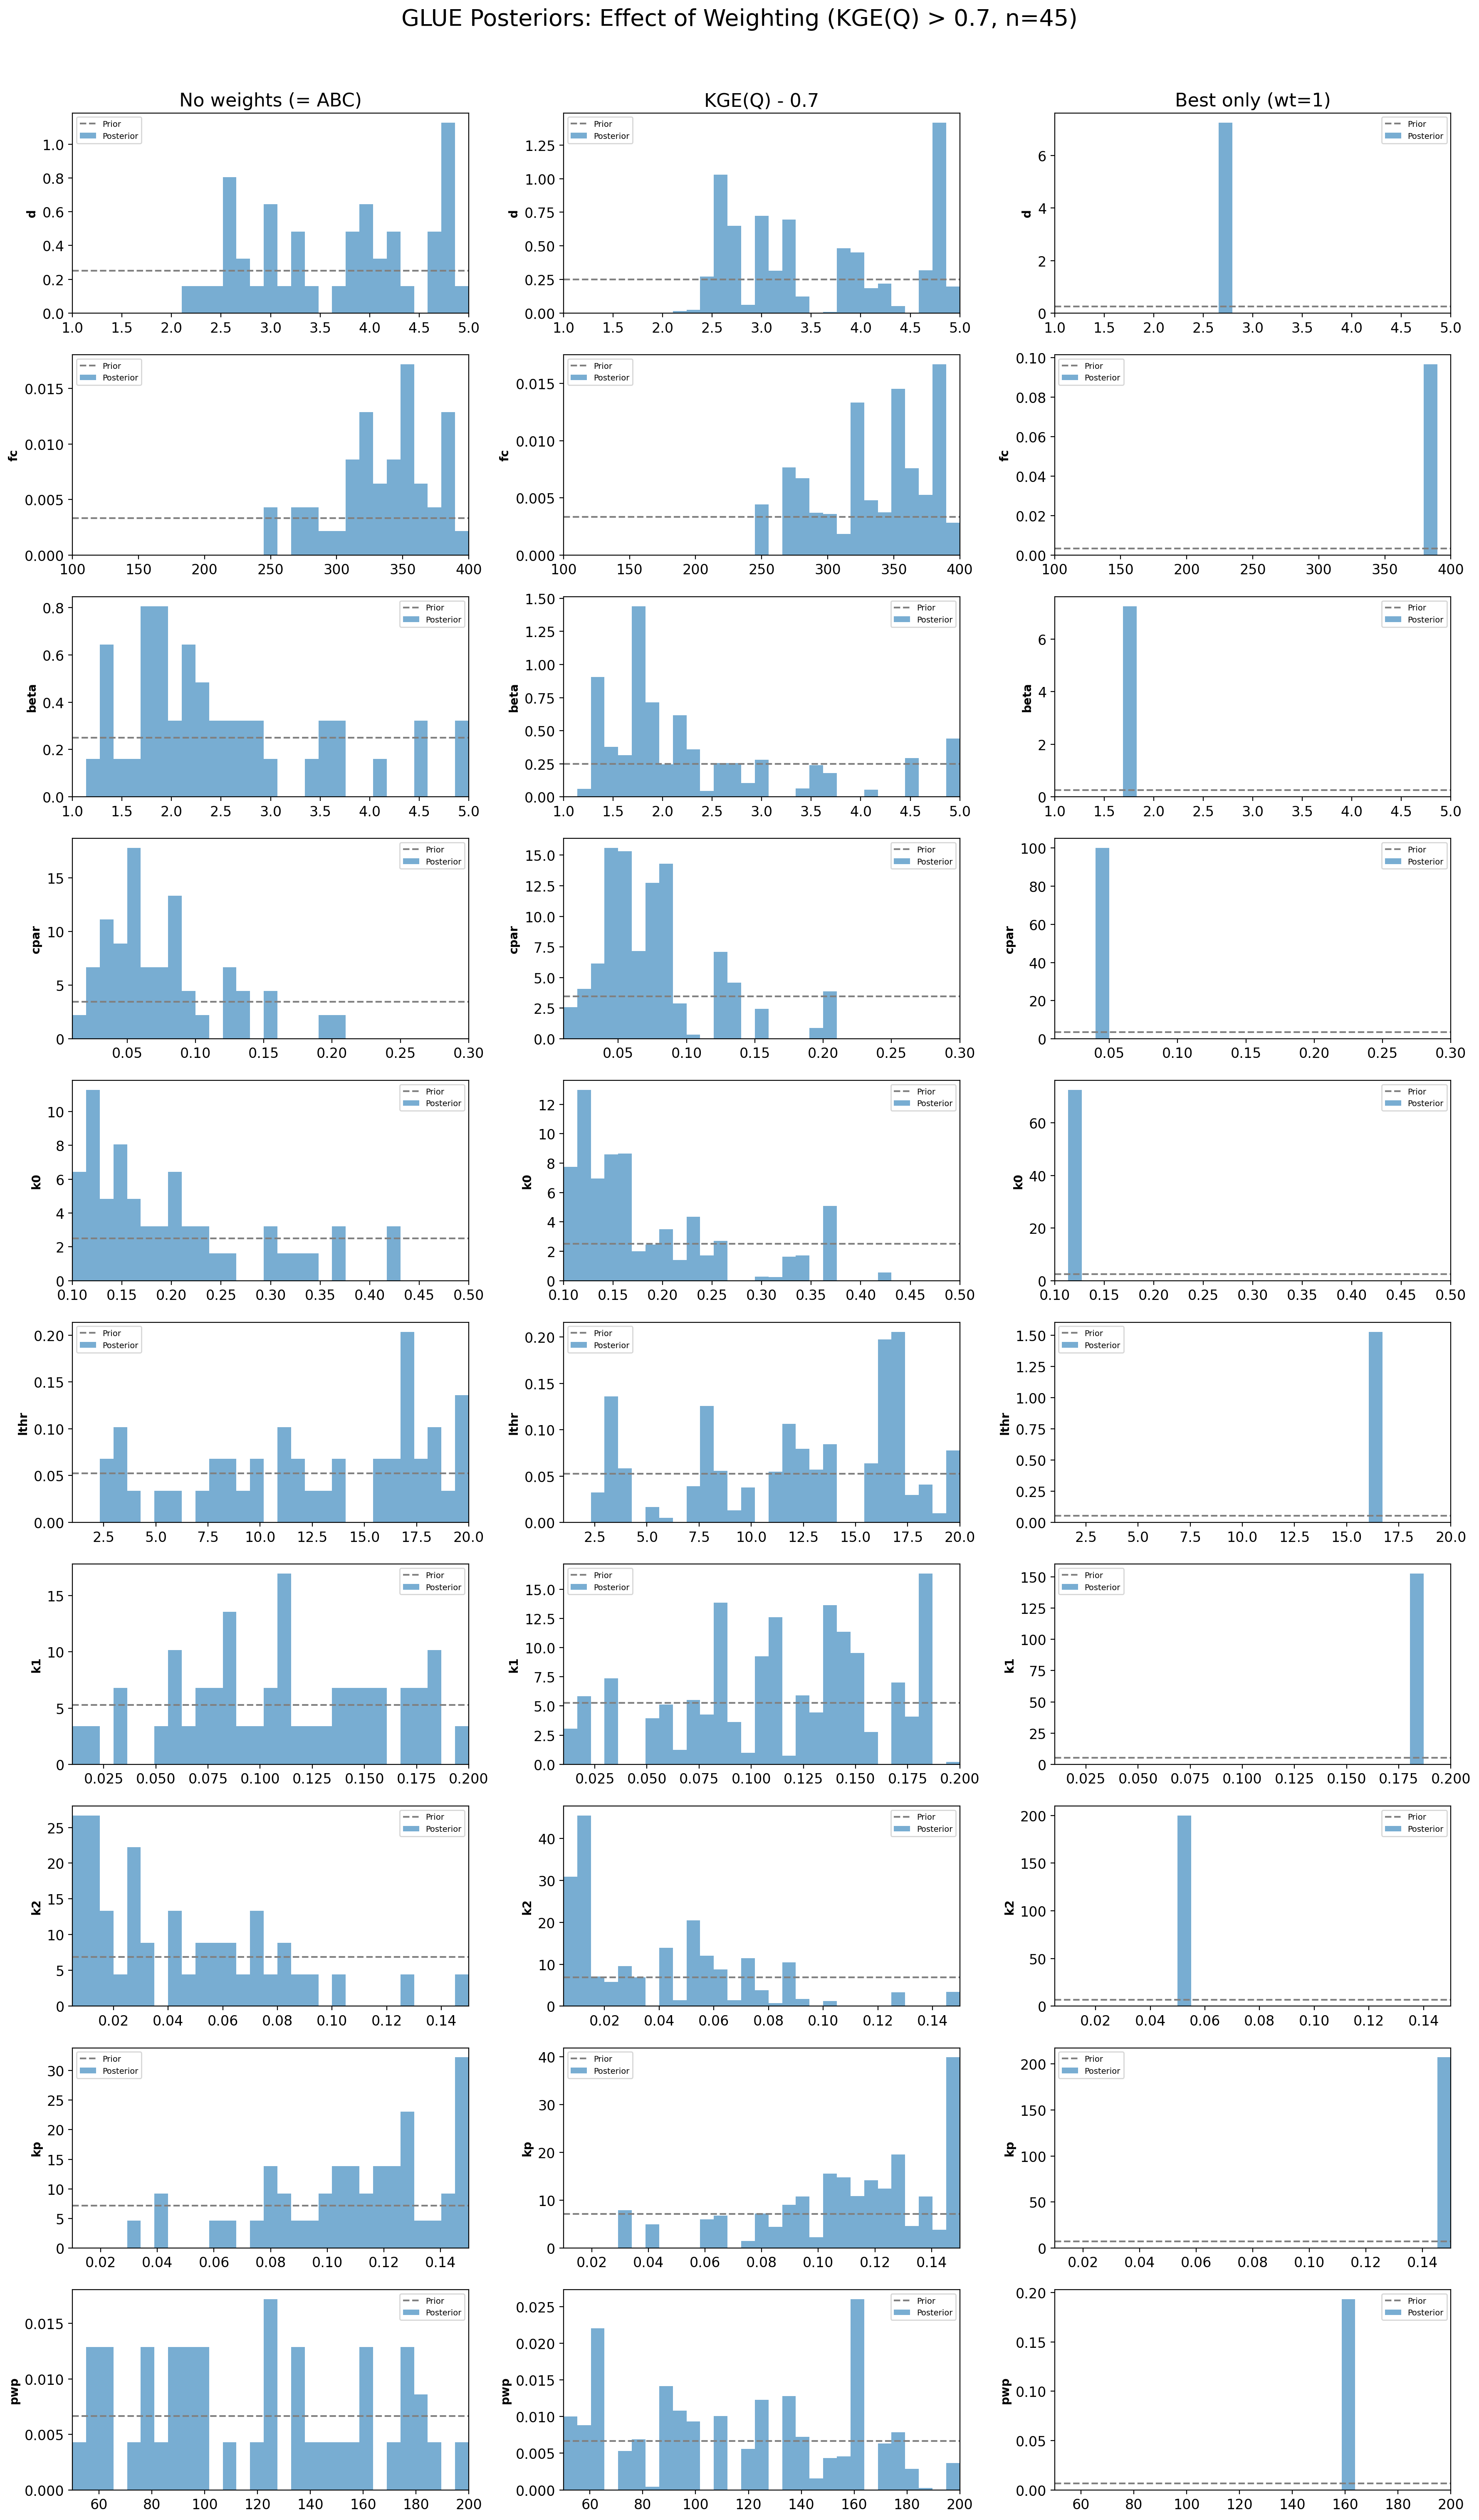

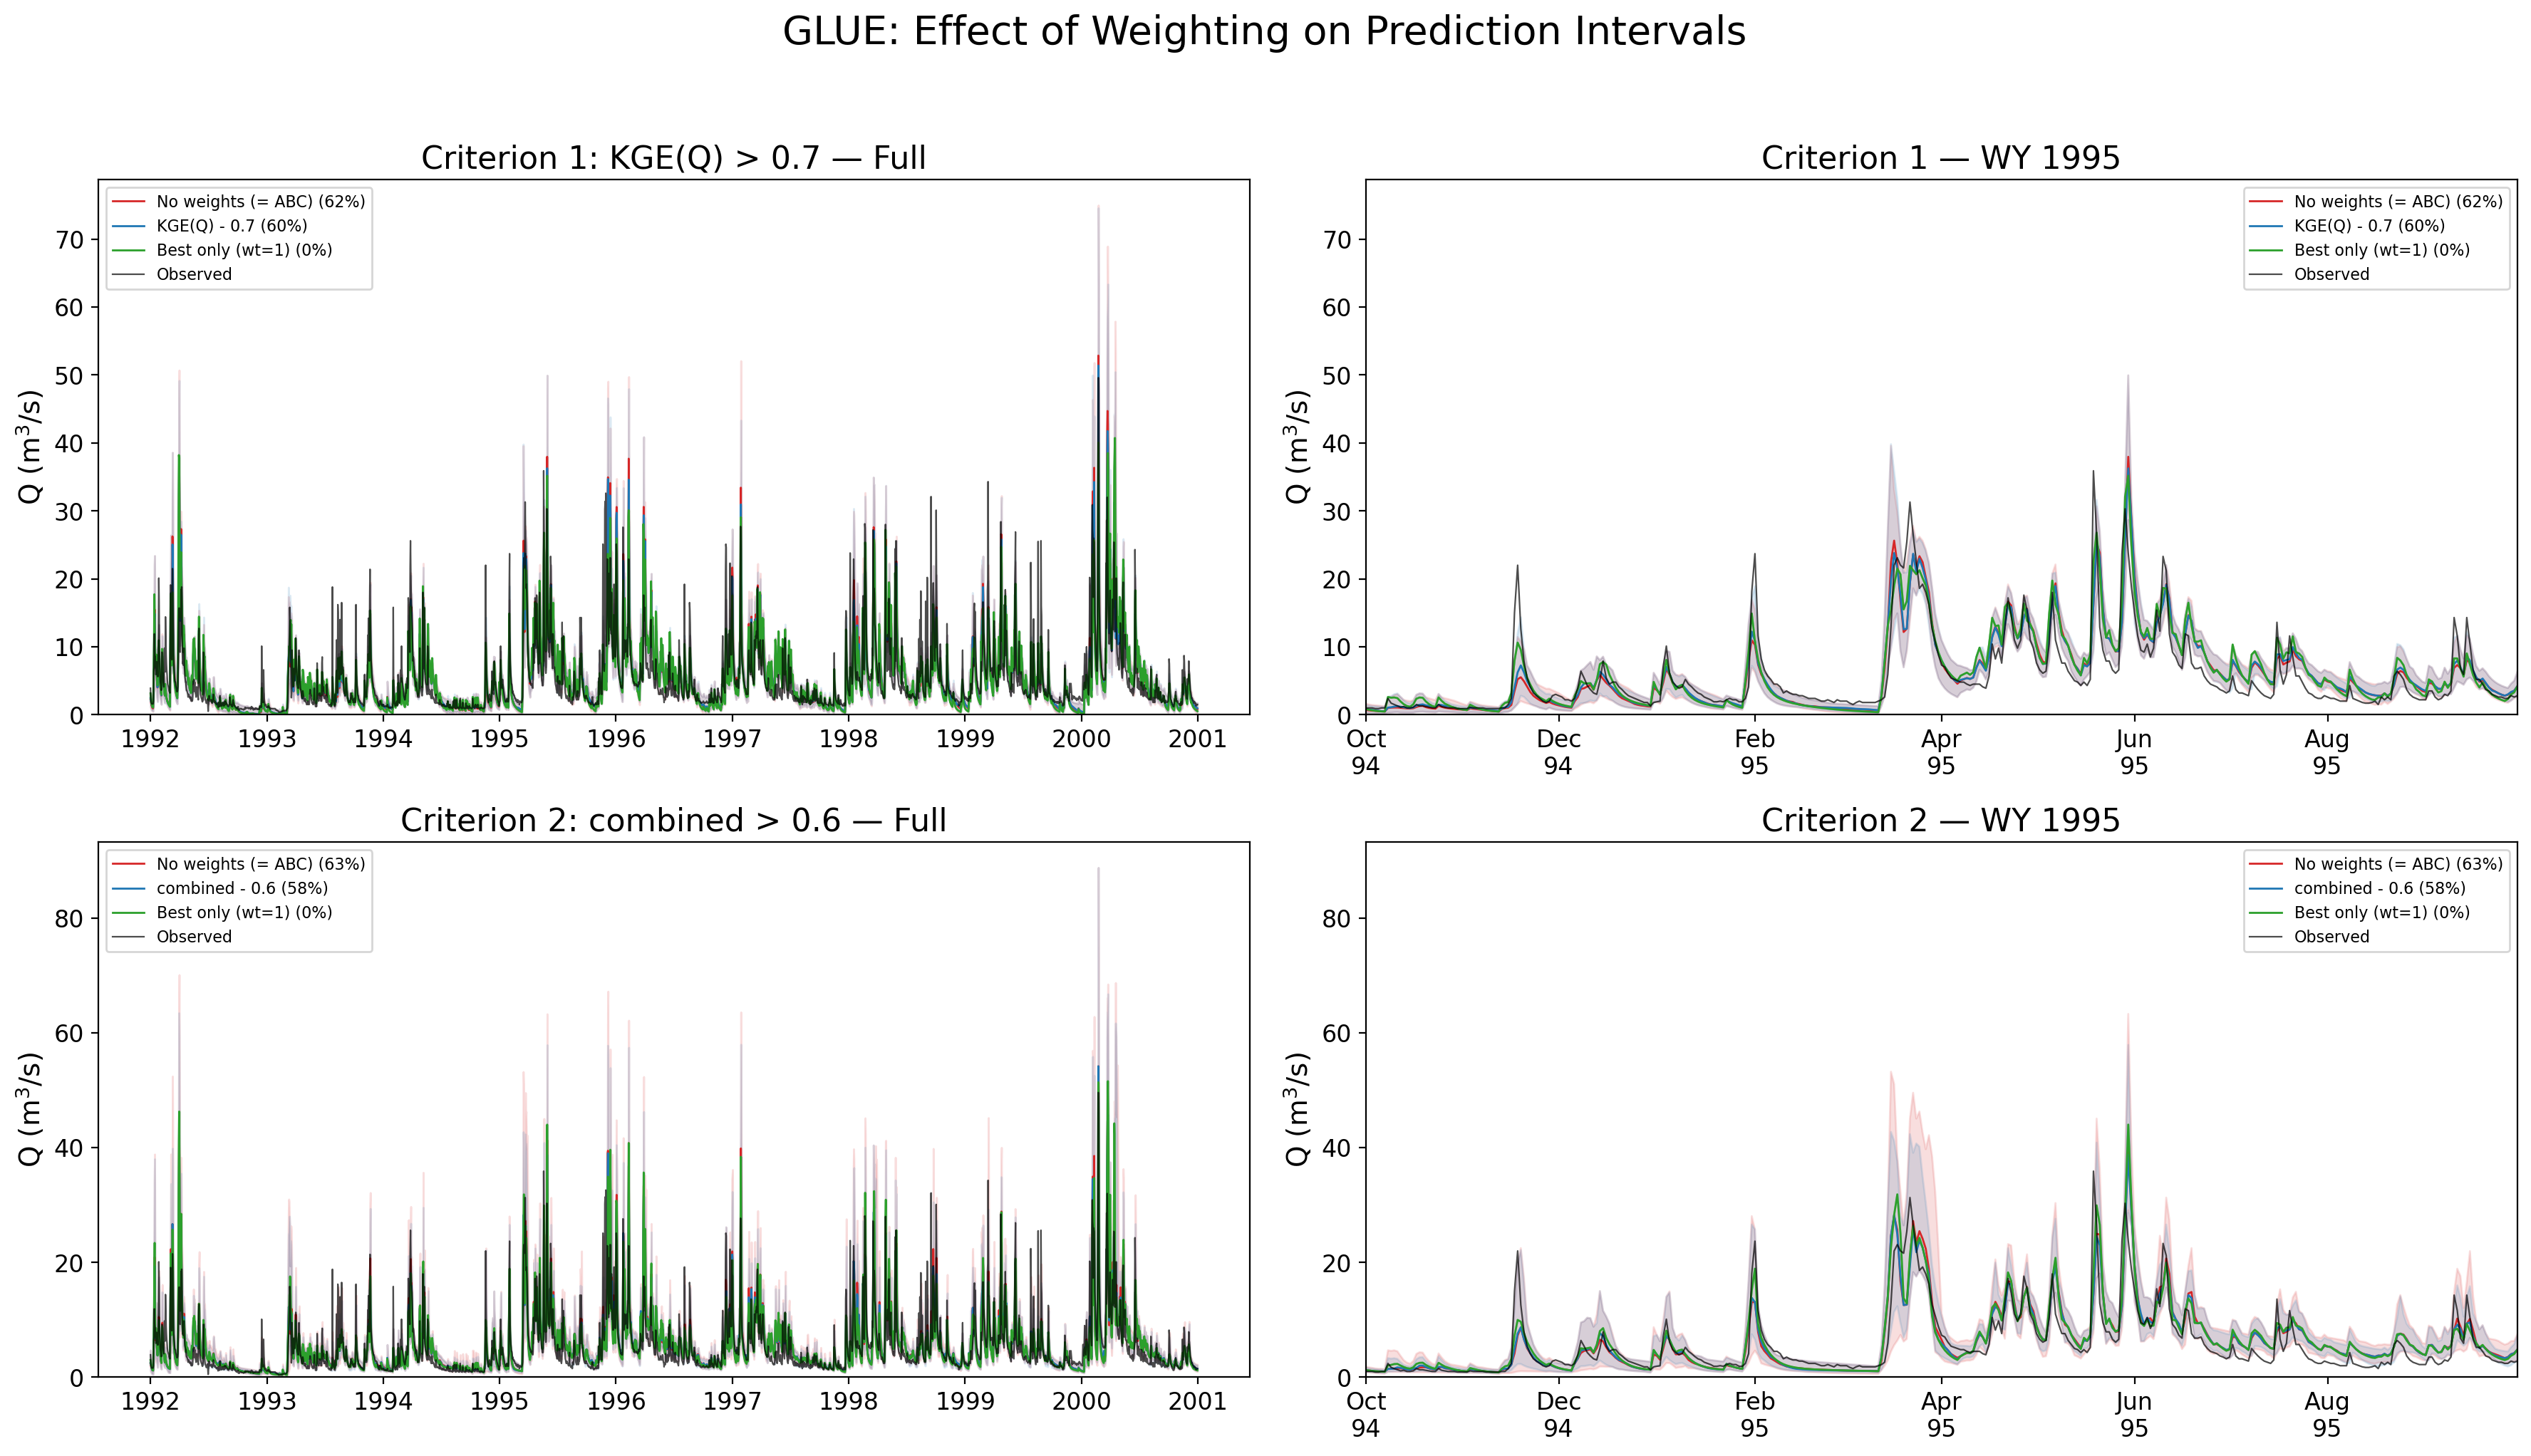

In [67]:
# --- GLUE: Effect of Weighting on Posterior Distributions (criterion 1) ---
fig, axes = plt.subplots(n_params, 3, figsize=(18, 3 * n_params))

for j, pname in enumerate(param_names):
    lo, hi = lower_bounds[j], upper_bounds[j]
    bins = np.linspace(lo, hi, 30)
    bin_width = bins[1] - bins[0]
    uniform_density = 1.0 / (hi - lo)

    for col, (name, w) in enumerate(weight_schemes_1):
        ax = axes[j, col]
        ax.axhline(uniform_density, color="gray", ls="--", lw=1.5, label="Prior")
        counts, _ = np.histogram(ensemble_params[glue_behavioral, j], bins=bins, weights=w)
        density = counts / bin_width
        ax.bar(bins[:-1], density, width=bin_width, alpha=0.6, color="C0", align="edge",
               label="Posterior")
        ax.set_ylabel(pname, fontsize=10, fontweight="bold")
        ax.set_xlim(lo, hi)
        if j == 0:
            ax.set_title(f"{name}")
        ax.legend(fontsize=7)

plt.suptitle(f"GLUE Posteriors: Effect of Weighting (KGE(Q) > {GLUE_THRESH_1}, n={n_glue})",
             fontsize=20, y=1.01)
plt.tight_layout()
plt.show()

# --- GLUE: Effect of Weighting on Prediction Intervals ---
colors = ["C3", "C0", "C2"]
fig, axes = plt.subplots(2, 2, figsize=(18, 10))

# Row 1: Criterion 1
for ax_idx, (ax, zoom) in enumerate(zip(axes[0], [False, True])):
    for (name, _), color in zip(weight_schemes_1, colors):
        pi = pi_results_1[name]
        ax.fill_between(time_post[:n_obs], pi["p5"][:n_obs], pi["p95"][:n_obs],
                        alpha=0.15, color=color)
        ax.plot(time_post[:n_obs], pi["p50"][:n_obs], color=color, lw=1,
                label=f"{name} ({pi['cont']:.0f}%)")
    ax.plot(time_post[:n_obs], obs_aligned, "k-", lw=0.8, alpha=0.7, label="Observed")
    ax.set_ylabel("Q (m$^3$/s)")
    ax.set_ylim(bottom=0)
    ax.legend(fontsize=8)
    if zoom:
        ax.set_xlim(pd.Timestamp("1994-10-01"), pd.Timestamp("1995-09-30"))
        ax.xaxis.set_major_locator(mdates.MonthLocator(interval=2))
        ax.xaxis.set_major_formatter(mdates.DateFormatter("%b\n%y"))
        ax.set_title(f"Criterion 1 — WY 1995")
    else:
        ax.set_title(f"Criterion 1: KGE(Q) > {GLUE_THRESH_1} — Full")

# Row 2: Criterion 2
for ax_idx, (ax, zoom) in enumerate(zip(axes[1], [False, True])):
    for (name, _), color in zip(weight_schemes_2, colors):
        pi = pi_results_2[name]
        ax.fill_between(time_post[:n_obs], pi["p5"][:n_obs], pi["p95"][:n_obs],
                        alpha=0.15, color=color)
        ax.plot(time_post[:n_obs], pi["p50"][:n_obs], color=color, lw=1,
                label=f"{name} ({pi['cont']:.0f}%)")
    ax.plot(time_post[:n_obs], obs_aligned, "k-", lw=0.8, alpha=0.7, label="Observed")
    ax.set_ylabel("Q (m$^3$/s)")
    ax.set_ylim(bottom=0)
    ax.legend(fontsize=8)
    if zoom:
        ax.set_xlim(pd.Timestamp("1994-10-01"), pd.Timestamp("1995-09-30"))
        ax.xaxis.set_major_locator(mdates.MonthLocator(interval=2))
        ax.xaxis.set_major_formatter(mdates.DateFormatter("%b\n%y"))
        ax.set_title(f"Criterion 2 — WY 1995")
    else:
        ax.set_title(f"Criterion 2: combined > {GLUE_THRESH_2} — Full")

plt.suptitle("GLUE: Effect of Weighting on Prediction Intervals", fontsize=20, y=1.02)
plt.tight_layout()
plt.show()

---
## Section 7: Observation Error Impact Summary

How does adding observation errors (σ(Q) = 0.10Q + 0.02) affect each calibration method?

In [63]:
# --- Observation Error Impact Summary ---
print("=" * 90)
print(f"{'Method':>25} | {'KGE(Q)':>8} {'clean':>5} | {'KGE(Q)':>8} {'noisy':>5} | {'KGE(1/Q)':>9} {'clean':>5} | {'KGE(1/Q)':>9} {'noisy':>5}")
print("-" * 90)
print(f"{'L-BFGS-B (best)':>25} | {lbfgsb_clean_kge:>13.4f} | {lbfgsb_noisy_kge:>13.4f} | {lbfgsb_clean_kge_inv:>14.4f} | {lbfgsb_noisy_kge_inv:>14.4f}")
print(f"{'PSO (best)':>25} | {pso_clean_kge:>13.4f} | {pso_noisy_kge:>13.4f} | {pso_clean_kge_inv:>14.4f} | {pso_noisy_kge_inv:>14.4f}")
print(f"{'ABC (mean, top 5%)':>25} | {abc_clean_mean_kge:>13.4f} | {abc_noisy_mean_kge:>13.4f} | {abc_clean_mean_kge_inv:>14.4f} | {abc_noisy_mean_kge_inv:>14.4f}")
print(f"{'GLUE (weighted mean)':>25} | {glue_clean_w_kge:>13.4f} | {glue_noisy_w_kge:>13.4f} | {glue_clean_w_kge_inv:>14.4f} | {glue_noisy_w_kge_inv:>14.4f}")
print("=" * 90)

                   Method |   KGE(Q) clean |   KGE(Q) noisy |  KGE(1/Q) clean |  KGE(1/Q) noisy
------------------------------------------------------------------------------------------


NameError: name 'lbfgsb_clean_kge' is not defined

---
## Section 8: Prior vs Posterior Distribution Comparison

For each Bayesian/uncertainty method (ABC, GLUE), we compare the **prior** and **posterior**
distributions for every parameter. This reveals which parameters are well-constrained by each
method and highlights differences in how each method updates the prior.

In [ ]:
fig, axes = plt.subplots(n_params, 2, figsize=(12, 3 * n_params))

for j, pname in enumerate(param_names):
    lo, hi = lower_bounds[j], upper_bounds[j]
    bins = np.linspace(lo, hi, 30)
    uniform_density = 1.0 / (hi - lo)

    # ABC posterior (top 5% by d1, equal weight)
    ax = axes[j, 0]
    ax.axhline(uniform_density, color="gray", ls="--", lw=1.5, label="Prior (uniform)")
    ax.hist(abc_results_Q["params"][:, j], bins=bins, alpha=0.6, density=True,
            color="C3", label="ABC posterior")
    ax.set_ylabel(pname, fontsize=10, fontweight="bold")
    if j == 0:
        ax.set_title("ABC (d1, equal weight)")
    ax.legend(fontsize=10)
    ax.set_xlim(lo, hi)

    # GLUE posterior (criterion 1, weighted)
    ax = axes[j, 1]
    ax.axhline(uniform_density, color="gray", ls="--", lw=1.5, label="Prior (uniform)")
    bin_width = bins[1] - bins[0]
    counts, _ = np.histogram(ensemble_params[glue_behavioral, j], bins=bins, weights=glue_weights)
    density = counts / bin_width
    ax.bar(bins[:-1], density, width=bin_width, alpha=0.6, color="C0", align="edge", label="GLUE posterior")
    if j == 0:
        ax.set_title("GLUE (KGE(Q), weighted)")
    ax.legend(fontsize=10)
    ax.set_xlim(lo, hi)

plt.suptitle("Prior vs Posterior: All Parameters — ABC & GLUE", fontsize=10, y=1.01)
plt.tight_layout()
plt.show()

---
## Section 9: Method Comparison Summary

In [78]:
# --- Method Comparison Summary Table ---
from IPython.display import display, HTML

rows = [
    ["Local Optimization: Gradient-based Method", "Local", "Deterministic", "Point estimate",
     f"{best_local['kge']:.4f}", f"{best_local['kge_inv']:.4f}",
     f"{sum(r['total_runs'] for r in lbfgsb_results)}",
     "No", "Different starting points only"],
    ["Global Optimization: Particle Swamp Optimization", "Global", "Deterministic", "Point estimate",
     f"{pso_kge:.4f}", f"{pso_kge_inv:.4f}",
     f"{30 * 100}",
     "No", "Within iteration across different particles"],
    [f"ABC 1-KGE(Q)<{eps_d1}", "Global", "Stochastic", "Equal-weight posterior",
     f"{np.nanmean(abc_kge_Q_vals[accepted_d1]):.4f}",
     f"{np.nanmean(abc_kge_inv[accepted_d1]):.4f}",
     f"{N_ABC}",
     f"Yes (n={abc_results_Q['n_accepted']})", "Fully parallel"],
    [f"ABC 1-(0.5*KGE(Q)+0.5*KGE(1/Q))<{eps_d2}", "Global", "Stochastic", "Equal-weight posterior",
     f"{np.nanmean(abc_kge_Q_vals[accepted_d2]):.4f}",
     f"{np.nanmean(abc_kge_inv[accepted_d2]):.4f}",
     f"{N_ABC}",
     f"Yes (n={abc_results_comb['n_accepted']})", "Fully parallel"],
    [f"GLUE KGE(Q)>{GLUE_THRESH_1}", "Global", "Stochastic", "Weighted pseudo-posterior",
     f"{np.sum(glue_w1_linear * ensemble_kge[glue_behavioral]):.4f}",
     f"{np.sum(glue_w1_linear * ensemble_kge_inv[glue_behavioral]):.4f}",
     f"{N_ENSEMBLE}",
     f"Yes (n={n_glue})", "Fully parallel"],
    [f"GLUE (0.5*KGE(Q)+0.5*KGE(1/Q))>{GLUE_THRESH_2}", "Global", "Stochastic", "Weighted pseudo-posterior",
     f"{np.sum(glue_w2_linear * ensemble_kge[glue_behavioral_comb]):.4f}",
     f"{np.sum(glue_w2_linear * ensemble_kge_inv[glue_behavioral_comb]):.4f}",
     f"{N_ENSEMBLE}",
     f"Yes (n={n_glue_comb})", "Fully parallel"],
]

header = ["Method", "Scope", "Type", "Output", "KGE(Q)", "KGE(1/Q)", "Model runs", "Uncertainty", "Parallelizable"]

html = '<table style="font-size:13px; border-collapse:collapse;">\n'
html += '<tr>' + ''.join(f'<th style="padding:6px 10px; border:1px solid #ccc; background:#f0f0f0;">{h}</th>' for h in header) + '</tr>\n'
for row in rows:
    html += '<tr>' + ''.join(f'<td style="padding:6px 10px; border:1px solid #ccc;">{v}</td>' for v in row) + '</tr>\n'
html += '</table>'

display(HTML(html))